#  UNCERTAINTY - RISE Summer school

In this notebook - we will cover some experimentation on sampling, ensembling and test time augmentation as well as preliminary work on conformal prediction.

# Part 1 - Sampling and bootstrapping

We will need data from ADNI - ADNIMERGE - All data in this workbook is available here <https://drive.google.com/drive/folders/1rdbQ65HaYchBkAy16Icw9mkjPSRwLUgF?usp=share_link>

In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
df_adni = pd.read_csv('ADNI/ADNIMERGE.csv')
df_adni_unique = df_adni.sort_values(['RID','EXAMDATE']).drop_duplicates('RID')
df_adniu = df_adni_unique.dropna(subset=['Hippocampus_bl','ICV_bl','AGE'])
df_adniu['HippoICV'] = df_adniu['Hippocampus_bl'] / df_adniu['ICV_bl']
df_adnius  = df_adniu.sort_values('AGE')

FileNotFoundError: [Errno 2] No such file or directory: 'ADNI/ADNIMERGE.csv'

In [ ]:
def bootstrap_mean(data,numb_bootstrap=1000):
    list_values = []
    for k in range(numb_bootstrap):
        samples = np.random.choice(data, size=data.size)
        list_values.append(samples.mean())
    return np.asarray(list_values).mean(), np.asarray(list_values).std(), np.asarray(list_values)

Get the bootstrapped mean for HippoICV when consider all samples, one in 10 or 1 in 50 samples, plot the boxplots and comment on what you observe

In [ ]:
m,s,l = bootstrap_mean(df_adnius['HippoICV'])
m2,s2,l2 = bootstrap_mean(np.asarray(df_adnius['HippoICV'])[::10])
m3,s3,l3 = bootstrap_mean(np.asarray(df_adnius['HippoICV'])[::50])

{'whiskers': [<matplotlib.lines.Line2D at 0x29d42df10>,
 'caps': [<matplotlib.lines.Line2D at 0x29d4ed490>,
 'boxes': [<matplotlib.lines.Line2D at 0x2985ec910>,
 'medians': [<matplotlib.lines.Line2D at 0x29d508e50>,
 'fliers': [<matplotlib.lines.Line2D at 0x29d1cbcd0>,
 'means': []}

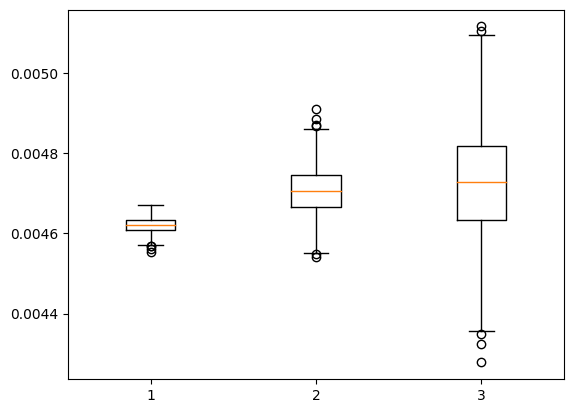

In [ ]:
temp = np.concatenate([l[:,None], l2[:,None],l3[:,None]],1)
plt.boxplot(temp)

In [ ]:
# Part 2 - Model ensembling and uncertainty measures

You will need some data originally coming from the 2017 WMH Segmentation challenge and readapted for these exercises. The data is available [here](https://liveuclac.sharepoint.com/:f:/s/MPHY0050/Emtiwhc_lxZAgP8VrLr__l0BAuUtOD0J91OWVUA7OcbsQg?e=arjzmD)

In [ ]:
# Setting up various plot functions to be used throughout the notebook

import matplotlib.pyplot as plt
import numpy as np
import random


def plot_images(images, title=None, figsize=(15,15)):
    f, axes = plt.subplots(1, len(images), figsize=figsize)
    for image_id, image in enumerate(images):
        axes[image_id].imshow(np.rot90(np.rot90(np.rot90(image))), cmap='gray')
        axes[image_id].axis('off')
        if not title:
            axes[image_id].set_title('Clinic {}'.format(image_id+1),
                                     fontsize=20)
        elif len(title) == 1:
            axes[image_id].set_title('Image {}: {}'.format(
                image_id, title[0]), fontsize=20)
        else:
            axes[image_id].set_title('Image {}: {}'.format(
                image_id, title[image_id]), fontsize=20)
    f.tight_layout()


def plot_grids(grids, figsize=(15,15)):
    f, axes = plt.subplots(1, len(grids), figsize=figsize)
    for grid_id, grid in enumerate(grids):
        grid_array = sitk.GetArrayViewFromImage(grid)
        axes[grid_id].imshow(np.flip(grid_array, axis=0),
               interpolation='hamming',
               cmap='gray',
               origin='lower')
        axes[grid_id].set_title('Grid {}'.format(grid_id), fontsize=20)
    f.tight_layout()


def plot_histograms(images, figsize=(15,7.5)):
    f, axes = plt.subplots(1, len(images), figsize=figsize)
    for image_id, image in enumerate(images):
        print(image_id)
        histogram, bins = np.histogram(image, bins=40)
        axes[image_id].set_xlim([0, 140])
        axes[image_id].hist(histogram, bins)
        axes[image_id].set_title('Clinic {} Histogram'.format(image_id),
                                 fontsize=20)
    f.tight_layout()
    f.show()

In [ ]:
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)

Let's define our model

In [ ]:
# import required libraries
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import os
import re
!pip install torchio
import torchio
from torchio import Subject
from torch.utils.data import DataLoader
import torchvision
from torchvision.transforms import Compose
from torchvision.transforms import RandomCrop

def initialize_weights(*models):
    for model in models:
        for module in model.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                nn.init.kaiming_normal(module.weight)
                if module.bias is not None:
                    module.bias.data.zero_()
            elif isinstance(module, nn.BatchNorm2d):
                module.weight.data.fill_(1)
                module.bias.data.zero_()

class _EncoderBN(nn.Module):
    def __init__(self, in_channels, out_channels,k ,padd , dropout=False):
        super(_EncoderBN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=k, padding=padd)
        self.BN1a = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=k, padding=padd)
        self.BN2a = nn.BatchNorm2d(out_channels)

    def forward(self,x):
        x = F.leaky_relu(self.BN1a(self.conv1(x)),inplace=True)
        x = F.leaky_relu(self.BN2a(self.conv2(x)),inplace=True)
        return x

class _DecoderBN(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super(_DecoderBN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, middle_channels, kernel_size=3,padding=1)
        self.BN1a = nn.BatchNorm2d(middle_channels)
        self.conv2 = nn.Conv2d(middle_channels, middle_channels, kernel_size=3, padding=1)
        self.BN2a = nn.BatchNorm2d(middle_channels)
        self.convT = nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        x = F.leaky_relu(self.BN1a(self.conv1(x)),inplace=True)
        x = F.leaky_relu(self.BN2a(self.conv2(x)),inplace=True)

        return self.convT(x)

class prefinalBN(nn.Module):
    def __init__(self, in_channels,out_channels):
        super(prefinalBN,self).__init__()

        self.conv1 = nn.Conv2d(in_channels , out_channels, kernel_size=3, padding=1)
        self.BN1a = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.BN2a = nn.BatchNorm2d(out_channels)
        nn.InstanceNorm1d

    def forward(self, x ):

        x = F.leaky_relu(self.BN1a(self.conv1(x)),inplace=True)
        x = F.leaky_relu(self.BN2a(self.conv2(x)),inplace=True)
        return x

class ADABN(nn.Module):
    def __init__(self, num_classes, num_channels):
        super(ADABN, self).__init__()

        self.enc1 = _EncoderBN(num_channels, 64, 5, 2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc2 = _EncoderBN(64, 96, 3, 1)
        self.enc3 = _EncoderBN(96, 128, 3, 1)
        self.enc4 = _EncoderBN(128, 256, 3, 1)
        self.center = _DecoderBN(256, 512, 256)
        self.dec4 = _DecoderBN(512, 256, 128)
        self.dec3 = _DecoderBN(256, 128, 96)
        self.dec2 = _DecoderBN(96 * 2, 96, 64)
        self.dec1 = prefinalBN(128,64)
        self.final = nn.Conv2d(64, num_classes, kernel_size=1)
        initialize_weights(self)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = F.dropout(self.enc4(self.pool(enc3)))

        center = self.center(self.pool(enc4))

        dec4 = self.dec4(torch.cat([center, enc4], 1))
        dec3 = self.dec3(torch.cat([dec4, enc3], 1))
        dec2 = self.dec2(torch.cat([dec3, enc2], 1))
        dec1 = self.dec1(torch.cat([dec2, enc1], 1))

        final = self.final(dec1)
        return (final, enc1, enc2, enc3, enc4, center, dec4, dec3, dec2, dec1)

model = ADABN(1,1)


/var/folders/9x/f7zq7s_d1fv5z99dsps_gk2m0000gn/T/ipykernel_4974/3841772280.py:11: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(module.weight)



Training a neural network to perform segmentation would require many iterations. 59 models have been trained and are saved in WMH_SegModels


In [ ]:
model1 = ADABN(1,1)
model2 = ADABN(1,1)

def loading_model(path,model):

    state_dict = torch.load(path)
    for key in list(state_dict.keys()):
        #print(key)
        state_dict[key[6:]] = state_dict.pop(key)
    #print(state_dict.keys())
    model.load_state_dict(state_dict)
    return model

model1 = loading_model('WMH_SegModels/model_4_cpu.pt',model1)
model2 = loading_model('WMH_SegModels/model_2_cpu.pt',model2)


/var/folders/9x/f7zq7s_d1fv5z99dsps_gk2m0000gn/T/ipykernel_4974/3841772280.py:11: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(module.weight)


odict_keys(['enc1.conv1.weight', 'enc1.conv1.bias', 'enc1.BN1a.weight', 'enc1.BN1a.bias', 'enc1.BN1a.running_mean', 'enc1.BN1a.running_var', 'enc1.BN1a.num_batches_tracked', 'enc1.conv2.weight', 'enc1.conv2.bias', 'enc1.BN2a.weight', 'enc1.BN2a.bias', 'enc1.BN2a.running_mean', 'enc1.BN2a.running_var', 'enc1.BN2a.num_batches_tracked', 'enc2.conv1.weight', 'enc2.conv1.bias', 'enc2.BN1a.weight', 'enc2.BN1a.bias', 'enc2.BN1a.running_mean', 'enc2.BN1a.running_var', 'enc2.BN1a.num_batches_tracked', 'enc2.conv2.weight', 'enc2.conv2.bias', 'enc2.BN2a.weight', 'enc2.BN2a.bias', 'enc2.BN2a.running_mean', 'enc2.BN2a.running_var', 'enc2.BN2a.num_batches_tracked', 'enc3.conv1.weight', 'enc3.conv1.bias', 'enc3.BN1a.weight', 'enc3.BN1a.bias', 'enc3.BN1a.running_mean', 'enc3.BN1a.running_var', 'enc3.BN1a.num_batches_tracked', 'enc3.conv2.weight', 'enc3.conv2.bias', 'enc3.BN2a.weight', 'enc3.BN2a.bias', 'enc3.BN2a.running_mean', 'enc3.BN2a.running_var', 'enc3.BN2a.num_batches_tracked', 'enc4.conv1.weig

In [ ]:


def getiosubjects(path_dir):
    subjects_list = sorted_alphanumeric(os.listdir( path_dir + '/FLAIR/'))

    iosubjects = []
    for slices in subjects_list:
        name_split = slices.split('_')
        subject = torchio.Subject(
          flair=torchio.ScalarImage(path_dir + '/FLAIR/' + slices),
          label=torchio.LabelMap(path_dir + '/Label/WMH_' +  slices.split('FLAIR_')[1]),

          name = name_split[1]+'_'+name_split[2]
      )
        iosubjects.append(subject)

    return iosubjects


target_validation_dir= 'Validation'
target_validation_subjects = getiosubjects(target_validation_dir)


# Training Sets
transforms = [torchio.CropOrPad(target_shape=[256,256,1]),
    torchio.RescaleIntensity(out_min_max=(0, 1))
]
transform = torchio.Compose(transforms)


target_dataset_validation = torchio.SubjectsDataset(target_validation_subjects, transform=transform)
target_validation_loader = DataLoader(target_dataset_validation, shuffle=False, batch_size=6)



### Let's Define a similarity measure
To evaluate and compare performances we need a similarity measure between ground truth and predicted segmentation. To this end we are going to use the  [dice similarity index](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient), Let's define the dice in PyTorch


In [ ]:

def pairwisedice(output,target):
    s = (10e-20)
    output = output > 0.8
    output = output.type(torch.FloatTensor)

    target = target == 1
    target = target.type(torch.FloatTensor)

    intersect = torch.sum(output * target)
    print(intersect, torch.sum(output), torch.sum(target))
    dice = (2 * intersect) / (torch.sum(output) + torch.sum(target) + s)

    return dice




In [ ]:
import random
from torch.autograd import Variable
import os
import time
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
import sys
import numpy as np
import nibabel as nib

# We define the inference function which get the prediction for all subjects.
# Note, the predictions are obtained on batch base
def inference(model, data_loader,batch_size=6,slices_per_image=24, model_name='model1'):
    slice_counter = 0
    dice = []
    with tqdm(total=len(data_loader), file=sys.stdout) as pbar:
        for slices in data_loader:
            if (slice_counter % slices_per_image) == 0:
                pred = torch.Tensor([])
                ref = torch.Tensor([])
                img = torch.Tensor([])
            batch_images = slices['flair']['data'][...,0].float()
            batch_labels = slices['label']['data'][...,0]
            #print(slices['name'][0])
            model.eval()
            outputs, _, _, _, _, _, _, _, _, _ = model(Variable(batch_images))

            pred = torch.cat((pred,torch.sigmoid(outputs)),0)
            ref = torch.cat((ref,batch_labels),0)
            img = torch.cat((img,batch_images),0)

            if pred.size(0)==slices_per_image:
                print(pred.size)
                save_name_pred = slices['name'][0]+'_pred'+model_name+'.nii.gz'
                save_name_img = slices['name'][0]+'_img'+model_name+'.nii.gz'
                save_name_ref = slices['name'][0]+'_ref'+model_name+'.nii.gz'
                nii_image_pred = nib.Nifti1Image(np.squeeze(pred.detach().numpy()),np.eye(4))
                nii_image_img = nib.Nifti1Image(np.squeeze(img.detach().numpy()),np.eye(4))
                nii_image_ref = nib.Nifti1Image(np.squeeze(ref.detach().numpy()),np.eye(4))
                print('Calculating dice', pred.size(), 'for ',save_name_pred)
                nib.save(nii_image_pred, save_name_pred)
                nib.save(nii_image_img, save_name_img)
                nib.save(nii_image_ref, save_name_ref)
                dice.append(pairwisedice(torch.squeeze(pred,1),torch.squeeze(ref,1)).item())
            slice_counter += batch_size
        pbar.update(1)
    return dice

In [ ]:
dice1 = inference(model1, target_validation_loader)

  0%|                                                                                                                                                                                                                                                                                                                                                | 0/69 [00:00<?, ?it/s]<built-in method size of Tensor object at 0x32859f830>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_100_predmodel1.nii.gz
tensor(966.) tensor(1061.) tensor(1767.)
<built-in method size of Tensor object at 0x32859c290>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_101_predmodel1.nii.gz
tensor(501.) tensor(654.) tensor(881.)
<built-in method size of Tensor object at 0x32859d610>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_102_predmodel1.nii.gz
tensor(624.) tensor(701.) tensor(1183.)
<built-in method size of Tensor object at 0x32859dbb0>
Calculating dice torch.Size([24, 1, 256, 256

  0%|                                                                                                                                                                                | 0/69 [00:00<?, ?it/s]<built-in method size of Tensor object at 0x15ed9d070>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_100_predmodel1.nii.gz
tensor(965.) tensor(1061.) tensor(1767.)
<built-in method size of Tensor object at 0x15ed9f0b0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_101_predmodel1.nii.gz
tensor(492.) tensor(642.) tensor(881.)
<built-in method size of Tensor object at 0x15ed9fe90>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_102_predmodel1.nii.gz
tensor(624.) tensor(710.) tensor(1183.)
<built-in method size of Tensor object at 0x15ed9cdd0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_103_predmodel1.nii.gz
tensor(4662.) tensor(4856.) tensor(6401.)
<built-in method size of Tensor object at 0x15ed9e510>
Calculating dice torch.

<built-in method size of Tensor object at 0x15ed9d1f0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_106_predmodel1.nii.gz
tensor(667.) tensor(773.) tensor(861.)
<built-in method size of Tensor object at 0x15eda70b0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_50_predmodel1.nii.gz
tensor(7515.) tensor(8343.) tensor(8561.)
<built-in method size of Tensor object at 0x15ed9d0d0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_51_predmodel1.nii.gz
tensor(7653.) tensor(8439.) tensor(8849.)
<built-in method size of Tensor object at 0x15edafdd0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_52_predmodel1.nii.gz
tensor(1334.) tensor(1650.) tensor(1648.)
<built-in method size of Tensor object at 0x15eda5910>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_53_predmodel1.nii.gz
tensor(218.) tensor(430.) tensor(381.)
<built-in method size of Tensor object at 0x15eda5c10>
Calculating dice torch.Size([24, 1, 256, 256]) for

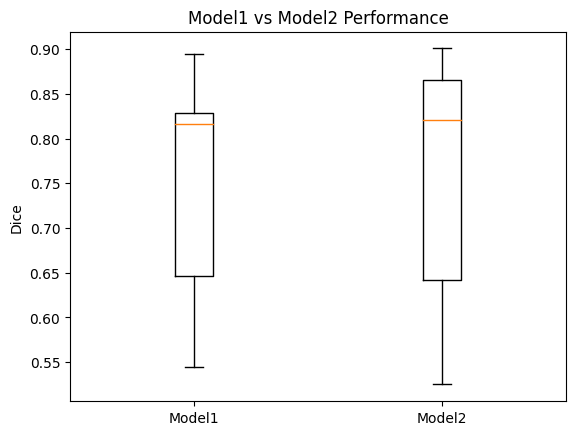

In [ ]:





# First we get the inference for  Clinic1 validation set
dice1=inference(model1, target_validation_loader, model_name='model1')
print("Done for model1")
dice2=inference(model2, target_validation_loader, model_name='model2')
print("Done for model2")

fig1, ax1 = plt.subplots()
ax1.set_title('Model1 vs Model2 Performance')
ax1.boxplot([dice1,dice2])

ax1.set_xticklabels(['Model1', 'Model2'])
ax1.get_xaxis().tick_bottom()
ax1.set_ylabel('Dice')

print('Model1 dice performance {}' .format(np.mean(dice1)))
print('Model2 dice performance {}' .format(np.mean(dice2)))




If you don't want to wait - the outputs have been saved in OutputsEnsembling for all models

In [ ]:
list_dsc = []
for k in range(1,60):
    model = ADABN(1,1)
    model = loading_model('WMH_SegModels/model_%d_cpu.pt'%k,model)
    list_dice = inference(model,target_validation_loader,batch_size=6,slices_per_image=24, model_name='model%d'%k)
    list_dsc.append(list_dice)


/var/folders/9x/f7zq7s_d1fv5z99dsps_gk2m0000gn/T/ipykernel_4974/3841772280.py:11: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(module.weight)


odict_keys(['enc1.conv1.weight', 'enc1.conv1.bias', 'enc1.BN1a.weight', 'enc1.BN1a.bias', 'enc1.BN1a.running_mean', 'enc1.BN1a.running_var', 'enc1.BN1a.num_batches_tracked', 'enc1.conv2.weight', 'enc1.conv2.bias', 'enc1.BN2a.weight', 'enc1.BN2a.bias', 'enc1.BN2a.running_mean', 'enc1.BN2a.running_var', 'enc1.BN2a.num_batches_tracked', 'enc2.conv1.weight', 'enc2.conv1.bias', 'enc2.BN1a.weight', 'enc2.BN1a.bias', 'enc2.BN1a.running_mean', 'enc2.BN1a.running_var', 'enc2.BN1a.num_batches_tracked', 'enc2.conv2.weight', 'enc2.conv2.bias', 'enc2.BN2a.weight', 'enc2.BN2a.bias', 'enc2.BN2a.running_mean', 'enc2.BN2a.running_var', 'enc2.BN2a.num_batches_tracked', 'enc3.conv1.weight', 'enc3.conv1.bias', 'enc3.BN1a.weight', 'enc3.BN1a.bias', 'enc3.BN1a.running_mean', 'enc3.BN1a.running_var', 'enc3.BN1a.num_batches_tracked', 'enc3.conv2.weight', 'enc3.conv2.bias', 'enc3.BN2a.weight', 'enc3.BN2a.bias', 'enc3.BN2a.running_mean', 'enc3.BN2a.running_var', 'enc3.BN2a.num_batches_tracked', 'enc4.conv1.weig

  0%|                                                                                                                                                                                | 0/69 [00:00<?, ?it/s]<built-in method size of Tensor object at 0x2985f77d0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_100_predmodel2.nii.gz
tensor(1088.) tensor(1222.) tensor(1767.)
<built-in method size of Tensor object at 0x2985f64b0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_101_predmodel2.nii.gz
tensor(601.) tensor(847.) tensor(881.)
<built-in method size of Tensor object at 0x2985f5130>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_102_predmodel2.nii.gz
tensor(606.) tensor(685.) tensor(1183.)
<built-in method size of Tensor object at 0x2985f7230>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_103_predmodel2.nii.gz
tensor(5409.) tensor(6099.) tensor(6401.)
<built-in method size of Tensor object at 0x2985f4ef0>
Calculating dice torch

tensor(6990.) tensor(7504.) tensor(8561.)
<built-in method size of Tensor object at 0x2985f6630>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_51_predmodel3.nii.gz
tensor(7501.) tensor(8183.) tensor(8849.)
<built-in method size of Tensor object at 0x2985f7530>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_52_predmodel3.nii.gz
tensor(1315.) tensor(1582.) tensor(1648.)
<built-in method size of Tensor object at 0x2985f74d0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_53_predmodel3.nii.gz
tensor(212.) tensor(357.) tensor(381.)
<built-in method size of Tensor object at 0x2985f6870>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_54_predmodel3.nii.gz
tensor(100.) tensor(259.) tensor(256.)
<built-in method size of Tensor object at 0x2985f4c50>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_4_predmodel3.nii.gz
tensor(9787.) tensor(11769.) tensor(11256.)
<built-in method size of Tensor object at 0x2985f7b30>
Calculatin

tensor(6977.) tensor(7428.) tensor(9570.)
  1%|██▍                                                                                                                                                                  | 1/69 [03:30<3:58:58, 210.86s/it]
odict_keys(['enc1.conv1.weight', 'enc1.conv1.bias', 'enc1.BN1a.weight', 'enc1.BN1a.bias', 'enc1.BN1a.running_mean', 'enc1.BN1a.running_var', 'enc1.BN1a.num_batches_tracked', 'enc1.conv2.weight', 'enc1.conv2.bias', 'enc1.BN2a.weight', 'enc1.BN2a.bias', 'enc1.BN2a.running_mean', 'enc1.BN2a.running_var', 'enc1.BN2a.num_batches_tracked', 'enc2.conv1.weight', 'enc2.conv1.bias', 'enc2.BN1a.weight', 'enc2.BN1a.bias', 'enc2.BN1a.running_mean', 'enc2.BN1a.running_var', 'enc2.BN1a.num_batches_tracked', 'enc2.conv2.weight', 'enc2.conv2.bias', 'enc2.BN2a.weight', 'enc2.BN2a.bias', 'enc2.BN2a.running_mean', 'enc2.BN2a.running_var', 'enc2.BN2a.num_batches_tracked', 'enc3.conv1.weight', 'enc3.conv1.bias', 'enc3.BN1a.weight', 'enc3.BN1a.bias', 'enc3.BN1a.runn

  0%|                                                                                                                                                                                | 0/69 [00:00<?, ?it/s]<built-in method size of Tensor object at 0x2985f7890>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_100_predmodel6.nii.gz
tensor(1140.) tensor(1389.) tensor(1767.)
<built-in method size of Tensor object at 0x2985f6450>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_101_predmodel6.nii.gz
tensor(586.) tensor(958.) tensor(881.)
<built-in method size of Tensor object at 0x2985f5790>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_102_predmodel6.nii.gz
tensor(679.) tensor(818.) tensor(1183.)
<built-in method size of Tensor object at 0x2985f5670>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_103_predmodel6.nii.gz
tensor(5429.) tensor(6110.) tensor(6401.)
<built-in method size of Tensor object at 0x2985f5910>
Calculating dice torch

<built-in method size of Tensor object at 0x2985f6030>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_50_predmodel7.nii.gz
tensor(6958.) tensor(7389.) tensor(8561.)
<built-in method size of Tensor object at 0x2985f5af0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_51_predmodel7.nii.gz
tensor(7036.) tensor(7363.) tensor(8849.)
<built-in method size of Tensor object at 0x2985f4c50>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_52_predmodel7.nii.gz
tensor(1273.) tensor(1467.) tensor(1648.)
<built-in method size of Tensor object at 0x2985f54f0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_53_predmodel7.nii.gz
tensor(209.) tensor(362.) tensor(381.)
<built-in method size of Tensor object at 0x2985f6450>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_54_predmodel7.nii.gz
tensor(116.) tensor(204.) tensor(256.)
<built-in method size of Tensor object at 0x2985f57f0>
Calculating dice torch.Size([24, 1, 256, 256]) for 

<built-in method size of Tensor object at 0x2985f43b0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_41_predmodel8.nii.gz
tensor(10700.) tensor(11636.) tensor(11998.)
<built-in method size of Tensor object at 0x2985f7cb0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_49_predmodel8.nii.gz
tensor(7273.) tensor(8004.) tensor(9570.)
  1%|████▋                                                                                                                                                                                                                                                                                                                                | 1/69 [02:14<2:32:38, 134.68s/it]
odict_keys(['enc1.conv1.weight', 'enc1.conv1.bias', 'enc1.BN1a.weight', 'enc1.BN1a.bias', 'enc1.BN1a.running_mean', 'enc1.BN1a.running_var', 'enc1.BN1a.num_batches_tracked', 'enc1.conv2.weight', 'enc1.conv2.bias', 'enc1.BN2a.weight', 'enc1.BN2a.bias', 'enc1.BN2a.running_mean'

  0%|                                                                                                                                                                                                                                                                                                                                                | 0/69 [00:00<?, ?it/s]<built-in method size of Tensor object at 0x2985f7dd0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_100_predmodel10.nii.gz
tensor(783.) tensor(817.) tensor(1767.)
<built-in method size of Tensor object at 0x2985f6f90>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_101_predmodel10.nii.gz
tensor(441.) tensor(499.) tensor(881.)
<built-in method size of Tensor object at 0x2985f7230>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_102_predmodel10.nii.gz
tensor(424.) tensor(442.) tensor(1183.)
<built-in method size of Tensor object at 0x2985f67b0>
Calculating dice torch.Size([24, 1, 256, 2

<built-in method size of Tensor object at 0x2985f6ab0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_105_predmodel11.nii.gz
tensor(2509.) tensor(2800.) tensor(3252.)
<built-in method size of Tensor object at 0x2985f77d0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_106_predmodel11.nii.gz
tensor(448.) tensor(460.) tensor(861.)
<built-in method size of Tensor object at 0x2985f6750>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_50_predmodel11.nii.gz
tensor(6435.) tensor(6717.) tensor(8561.)
<built-in method size of Tensor object at 0x2985f5d90>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_51_predmodel11.nii.gz
tensor(6582.) tensor(6832.) tensor(8849.)
<built-in method size of Tensor object at 0x2985f4d70>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_52_predmodel11.nii.gz
tensor(1243.) tensor(1468.) tensor(1648.)
<built-in method size of Tensor object at 0x2985f5fd0>
Calculating dice torch.Size([24, 1, 256, 

<built-in method size of Tensor object at 0x2985f7110>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_4_predmodel12.nii.gz
tensor(9332.) tensor(10961.) tensor(11256.)
<built-in method size of Tensor object at 0x2985f4d70>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_6_predmodel12.nii.gz
tensor(190.) tensor(215.) tensor(678.)
<built-in method size of Tensor object at 0x2985f75f0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_8_predmodel12.nii.gz
tensor(226.) tensor(268.) tensor(544.)
<built-in method size of Tensor object at 0x2985f7a70>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_41_predmodel12.nii.gz
tensor(10456.) tensor(11248.) tensor(11998.)
<built-in method size of Tensor object at 0x2985f6db0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_49_predmodel12.nii.gz
tensor(6864.) tensor(7287.) tensor(9570.)
  1%|████▋                                                                                                   

  0%|                                                                                                                                                                                                                                                                                                                                                | 0/69 [00:00<?, ?it/s]<built-in method size of Tensor object at 0x2985f5af0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_100_predmodel14.nii.gz
tensor(967.) tensor(1072.) tensor(1767.)
<built-in method size of Tensor object at 0x2985f61b0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_101_predmodel14.nii.gz
tensor(548.) tensor(713.) tensor(881.)
<built-in method size of Tensor object at 0x2985f58b0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_102_predmodel14.nii.gz
tensor(514.) tensor(570.) tensor(1183.)
<built-in method size of Tensor object at 0x2985f5df0>
Calculating dice torch.Size([24, 1, 256, 

<built-in method size of Tensor object at 0x2985f51f0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_105_predmodel15.nii.gz
tensor(2726.) tensor(3229.) tensor(3252.)
<built-in method size of Tensor object at 0x2985f4a10>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_106_predmodel15.nii.gz
tensor(518.) tensor(537.) tensor(861.)
<built-in method size of Tensor object at 0x2985f66f0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_50_predmodel15.nii.gz
tensor(6889.) tensor(7500.) tensor(8561.)
<built-in method size of Tensor object at 0x2985f7a70>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_51_predmodel15.nii.gz
tensor(7336.) tensor(7895.) tensor(8849.)
<built-in method size of Tensor object at 0x2985f4dd0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_52_predmodel15.nii.gz
tensor(1315.) tensor(1619.) tensor(1648.)
<built-in method size of Tensor object at 0x2985f4530>
Calculating dice torch.Size([24, 1, 256, 

<built-in method size of Tensor object at 0x2985f5910>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_4_predmodel16.nii.gz
tensor(10128.) tensor(12921.) tensor(11256.)
<built-in method size of Tensor object at 0x2986262d0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_6_predmodel16.nii.gz
tensor(312.) tensor(514.) tensor(678.)
<built-in method size of Tensor object at 0x2985f6270>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_8_predmodel16.nii.gz
tensor(307.) tensor(728.) tensor(544.)
<built-in method size of Tensor object at 0x2985f65d0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_41_predmodel16.nii.gz
tensor(10902.) tensor(12118.) tensor(11998.)
<built-in method size of Tensor object at 0x298625550>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_49_predmodel16.nii.gz
tensor(7636.) tensor(8829.) tensor(9570.)
  1%|████▋                                                                                                  

  0%|                                                                                                                                                                                                                                                                                                                                                | 0/69 [00:00<?, ?it/s]<built-in method size of Tensor object at 0x2985f76b0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_100_predmodel18.nii.gz
tensor(1117.) tensor(1305.) tensor(1767.)
<built-in method size of Tensor object at 0x2985f5070>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_101_predmodel18.nii.gz
tensor(607.) tensor(887.) tensor(881.)
<built-in method size of Tensor object at 0x2985f5a30>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_102_predmodel18.nii.gz
tensor(652.) tensor(792.) tensor(1183.)
<built-in method size of Tensor object at 0x2985f57f0>
Calculating dice torch.Size([24, 1, 256,

<built-in method size of Tensor object at 0x2985f6270>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_105_predmodel19.nii.gz
tensor(2213.) tensor(2405.) tensor(3252.)
<built-in method size of Tensor object at 0x2985f51f0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_106_predmodel19.nii.gz
tensor(534.) tensor(576.) tensor(861.)
<built-in method size of Tensor object at 0x2985f52b0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_50_predmodel19.nii.gz
tensor(5973.) tensor(6232.) tensor(8561.)
<built-in method size of Tensor object at 0x2985f67b0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_51_predmodel19.nii.gz
tensor(6387.) tensor(6572.) tensor(8849.)
<built-in method size of Tensor object at 0x2985f5a30>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_52_predmodel19.nii.gz
tensor(1224.) tensor(1408.) tensor(1648.)
<built-in method size of Tensor object at 0x2985f7530>
Calculating dice torch.Size([24, 1, 256, 

<built-in method size of Tensor object at 0x2985f4cb0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_6_predmodel20.nii.gz
tensor(231.) tensor(270.) tensor(678.)
<built-in method size of Tensor object at 0x2985f5850>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_8_predmodel20.nii.gz
tensor(206.) tensor(287.) tensor(544.)
<built-in method size of Tensor object at 0x2985f5310>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_41_predmodel20.nii.gz
tensor(10444.) tensor(11298.) tensor(11998.)
<built-in method size of Tensor object at 0x2985f6bd0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_49_predmodel20.nii.gz
tensor(7145.) tensor(7710.) tensor(9570.)
  1%|████▋                                                                                                                                                                                                                                                                                       

  0%|                                                                                                                                                                                                                                                                                                                                                | 0/69 [00:00<?, ?it/s]<built-in method size of Tensor object at 0x2985f4950>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_100_predmodel22.nii.gz
tensor(952.) tensor(1028.) tensor(1767.)
<built-in method size of Tensor object at 0x2985f5a30>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_101_predmodel22.nii.gz
tensor(561.) tensor(735.) tensor(881.)
<built-in method size of Tensor object at 0x2985f4410>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_102_predmodel22.nii.gz
tensor(562.) tensor(619.) tensor(1183.)
<built-in method size of Tensor object at 0x2985f7350>
Calculating dice torch.Size([24, 1, 256, 

<built-in method size of Tensor object at 0x298626e70>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_105_predmodel23.nii.gz
tensor(2685.) tensor(3058.) tensor(3252.)
<built-in method size of Tensor object at 0x298625c10>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_106_predmodel23.nii.gz
tensor(581.) tensor(668.) tensor(861.)
<built-in method size of Tensor object at 0x298626bd0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_50_predmodel23.nii.gz
tensor(6826.) tensor(7304.) tensor(8561.)
<built-in method size of Tensor object at 0x298627350>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_51_predmodel23.nii.gz
tensor(6842.) tensor(7146.) tensor(8849.)
<built-in method size of Tensor object at 0x2986240b0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_52_predmodel23.nii.gz
tensor(1312.) tensor(1533.) tensor(1648.)
<built-in method size of Tensor object at 0x298626210>
Calculating dice torch.Size([24, 1, 256, 

<built-in method size of Tensor object at 0x298624530>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_4_predmodel24.nii.gz
tensor(9834.) tensor(12428.) tensor(11256.)
<built-in method size of Tensor object at 0x298624170>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_6_predmodel24.nii.gz
tensor(266.) tensor(337.) tensor(678.)
<built-in method size of Tensor object at 0x2986244d0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_8_predmodel24.nii.gz
tensor(241.) tensor(521.) tensor(544.)
<built-in method size of Tensor object at 0x298627cb0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_41_predmodel24.nii.gz
tensor(10610.) tensor(11763.) tensor(11998.)
<built-in method size of Tensor object at 0x298626a50>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_49_predmodel24.nii.gz
tensor(7407.) tensor(8106.) tensor(9570.)
  1%|████▋                                                                                                   

  0%|                                                                                                                                                                                                                                                                                                                                                | 0/69 [00:00<?, ?it/s]<built-in method size of Tensor object at 0x298626ff0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_100_predmodel26.nii.gz
tensor(1004.) tensor(1093.) tensor(1767.)
<built-in method size of Tensor object at 0x298626870>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_101_predmodel26.nii.gz
tensor(537.) tensor(668.) tensor(881.)
<built-in method size of Tensor object at 0x2986253d0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_102_predmodel26.nii.gz
tensor(518.) tensor(581.) tensor(1183.)
<built-in method size of Tensor object at 0x2986249b0>
Calculating dice torch.Size([24, 1, 256,

<built-in method size of Tensor object at 0x298626c30>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_105_predmodel27.nii.gz
tensor(2475.) tensor(2730.) tensor(3252.)
<built-in method size of Tensor object at 0x298627a10>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_106_predmodel27.nii.gz
tensor(468.) tensor(479.) tensor(861.)
<built-in method size of Tensor object at 0x298626a50>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_50_predmodel27.nii.gz
tensor(6045.) tensor(6192.) tensor(8561.)
<built-in method size of Tensor object at 0x2986270b0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_51_predmodel27.nii.gz
tensor(6003.) tensor(6104.) tensor(8849.)
<built-in method size of Tensor object at 0x298627a70>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_52_predmodel27.nii.gz
tensor(1196.) tensor(1387.) tensor(1648.)
<built-in method size of Tensor object at 0x298625370>
Calculating dice torch.Size([24, 1, 256, 

<built-in method size of Tensor object at 0x298627650>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_4_predmodel28.nii.gz
tensor(9168.) tensor(10480.) tensor(11256.)
<built-in method size of Tensor object at 0x298625f70>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_6_predmodel28.nii.gz
tensor(272.) tensor(375.) tensor(678.)
<built-in method size of Tensor object at 0x298627bf0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_8_predmodel28.nii.gz
tensor(223.) tensor(323.) tensor(544.)
<built-in method size of Tensor object at 0x2986269f0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_41_predmodel28.nii.gz
tensor(10379.) tensor(10980.) tensor(11998.)
<built-in method size of Tensor object at 0x298626e10>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_49_predmodel28.nii.gz
tensor(6873.) tensor(7182.) tensor(9570.)
  1%|████▋                                                                                                   

  0%|                                                                                                                                                                                                                                                                                                                                                | 0/69 [00:00<?, ?it/s]<built-in method size of Tensor object at 0x298625490>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_100_predmodel30.nii.gz
tensor(951.) tensor(1065.) tensor(1767.)
<built-in method size of Tensor object at 0x298627bf0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_101_predmodel30.nii.gz
tensor(492.) tensor(652.) tensor(881.)
<built-in method size of Tensor object at 0x298624290>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_102_predmodel30.nii.gz
tensor(526.) tensor(586.) tensor(1183.)
<built-in method size of Tensor object at 0x298627890>
Calculating dice torch.Size([24, 1, 256, 

<built-in method size of Tensor object at 0x298624050>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_105_predmodel31.nii.gz
tensor(2645.) tensor(3057.) tensor(3252.)
<built-in method size of Tensor object at 0x2986248f0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_106_predmodel31.nii.gz
tensor(631.) tensor(694.) tensor(861.)
<built-in method size of Tensor object at 0x298624770>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_50_predmodel31.nii.gz
tensor(6713.) tensor(7075.) tensor(8561.)
<built-in method size of Tensor object at 0x298625f70>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_51_predmodel31.nii.gz
tensor(6942.) tensor(7430.) tensor(8849.)
<built-in method size of Tensor object at 0x298627f50>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_52_predmodel31.nii.gz
tensor(1281.) tensor(1523.) tensor(1648.)
<built-in method size of Tensor object at 0x298624a10>
Calculating dice torch.Size([24, 1, 256, 

<built-in method size of Tensor object at 0x2986276b0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_4_predmodel32.nii.gz
tensor(9638.) tensor(11451.) tensor(11256.)
<built-in method size of Tensor object at 0x298626a50>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_6_predmodel32.nii.gz
tensor(265.) tensor(346.) tensor(678.)
<built-in method size of Tensor object at 0x2986246b0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_8_predmodel32.nii.gz
tensor(258.) tensor(406.) tensor(544.)
<built-in method size of Tensor object at 0x298626bd0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_41_predmodel32.nii.gz
tensor(10324.) tensor(10927.) tensor(11998.)
<built-in method size of Tensor object at 0x298625d90>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_49_predmodel32.nii.gz
tensor(7321.) tensor(7953.) tensor(9570.)
  1%|████▋                                                                                                   

  0%|                                                                                                                                                                                                                                                                                                                                                | 0/69 [00:00<?, ?it/s]<built-in method size of Tensor object at 0x298626ff0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_100_predmodel34.nii.gz
tensor(1042.) tensor(1204.) tensor(1767.)
<built-in method size of Tensor object at 0x298627d10>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_101_predmodel34.nii.gz
tensor(583.) tensor(742.) tensor(881.)
<built-in method size of Tensor object at 0x298625850>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_102_predmodel34.nii.gz
tensor(584.) tensor(651.) tensor(1183.)
<built-in method size of Tensor object at 0x298626f90>
Calculating dice torch.Size([24, 1, 256,

<built-in method size of Tensor object at 0x2986264b0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_105_predmodel35.nii.gz
tensor(2652.) tensor(3100.) tensor(3252.)
<built-in method size of Tensor object at 0x298625070>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_106_predmodel35.nii.gz
tensor(573.) tensor(610.) tensor(861.)
<built-in method size of Tensor object at 0x298625cd0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_50_predmodel35.nii.gz
tensor(6881.) tensor(7354.) tensor(8561.)
<built-in method size of Tensor object at 0x298627290>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_51_predmodel35.nii.gz
tensor(7065.) tensor(7457.) tensor(8849.)
<built-in method size of Tensor object at 0x298624290>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_52_predmodel35.nii.gz
tensor(1286.) tensor(1564.) tensor(1648.)
<built-in method size of Tensor object at 0x298627cb0>
Calculating dice torch.Size([24, 1, 256, 

<built-in method size of Tensor object at 0x298627410>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_4_predmodel36.nii.gz
tensor(9996.) tensor(12520.) tensor(11256.)
<built-in method size of Tensor object at 0x2986268d0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_6_predmodel36.nii.gz
tensor(286.) tensor(360.) tensor(678.)
<built-in method size of Tensor object at 0x2986243b0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_8_predmodel36.nii.gz
tensor(229.) tensor(416.) tensor(544.)
<built-in method size of Tensor object at 0x2986275f0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_41_predmodel36.nii.gz
tensor(10608.) tensor(11538.) tensor(11998.)
<built-in method size of Tensor object at 0x298624890>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_49_predmodel36.nii.gz
tensor(7286.) tensor(8021.) tensor(9570.)
  1%|████▋                                                                                                   

  0%|                                                                                                                                                                                                                                                                                                                                                | 0/69 [00:00<?, ?it/s]<built-in method size of Tensor object at 0x298626f30>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_100_predmodel38.nii.gz
tensor(1216.) tensor(1407.) tensor(1767.)
<built-in method size of Tensor object at 0x298626990>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_101_predmodel38.nii.gz
tensor(660.) tensor(1028.) tensor(881.)
<built-in method size of Tensor object at 0x2986275f0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_102_predmodel38.nii.gz
tensor(716.) tensor(867.) tensor(1183.)
<built-in method size of Tensor object at 0x298626630>
Calculating dice torch.Size([24, 1, 256

<built-in method size of Tensor object at 0x298627e90>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_105_predmodel39.nii.gz
tensor(2546.) tensor(2839.) tensor(3252.)
<built-in method size of Tensor object at 0x298625190>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_106_predmodel39.nii.gz
tensor(603.) tensor(660.) tensor(861.)
<built-in method size of Tensor object at 0x298627170>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_50_predmodel39.nii.gz
tensor(6440.) tensor(6677.) tensor(8561.)
<built-in method size of Tensor object at 0x298624650>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_51_predmodel39.nii.gz
tensor(6524.) tensor(6724.) tensor(8849.)
<built-in method size of Tensor object at 0x298626570>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_52_predmodel39.nii.gz
tensor(1151.) tensor(1324.) tensor(1648.)
<built-in method size of Tensor object at 0x298626b70>
Calculating dice torch.Size([24, 1, 256, 

<built-in method size of Tensor object at 0x298627110>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_6_predmodel40.nii.gz
tensor(189.) tensor(196.) tensor(678.)
<built-in method size of Tensor object at 0x298626bd0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_8_predmodel40.nii.gz
tensor(170.) tensor(199.) tensor(544.)
<built-in method size of Tensor object at 0x298626270>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_41_predmodel40.nii.gz
tensor(10480.) tensor(11414.) tensor(11998.)
<built-in method size of Tensor object at 0x298627c50>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_49_predmodel40.nii.gz
tensor(6369.) tensor(6679.) tensor(9570.)
  1%|████▋                                                                                                                                                                                                                                                                                       

  0%|                                                                                                                                                                                                                                                                                                                                                | 0/69 [00:00<?, ?it/s]<built-in method size of Tensor object at 0x2986262d0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_100_predmodel42.nii.gz
tensor(1069.) tensor(1186.) tensor(1767.)
<built-in method size of Tensor object at 0x298625070>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_101_predmodel42.nii.gz
tensor(578.) tensor(753.) tensor(881.)
<built-in method size of Tensor object at 0x2986270b0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_102_predmodel42.nii.gz
tensor(575.) tensor(643.) tensor(1183.)
<built-in method size of Tensor object at 0x298625190>
Calculating dice torch.Size([24, 1, 256,

<built-in method size of Tensor object at 0x298625f10>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_105_predmodel43.nii.gz
tensor(2738.) tensor(3586.) tensor(3252.)
<built-in method size of Tensor object at 0x2986260f0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_106_predmodel43.nii.gz
tensor(737.) tensor(1060.) tensor(861.)
<built-in method size of Tensor object at 0x298626810>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_50_predmodel43.nii.gz
tensor(7195.) tensor(8017.) tensor(8561.)
<built-in method size of Tensor object at 0x298627f50>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_51_predmodel43.nii.gz
tensor(7155.) tensor(7683.) tensor(8849.)
<built-in method size of Tensor object at 0x2986267b0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_52_predmodel43.nii.gz
tensor(1354.) tensor(1637.) tensor(1648.)
<built-in method size of Tensor object at 0x2986274d0>
Calculating dice torch.Size([24, 1, 256,

<built-in method size of Tensor object at 0x298626d50>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_4_predmodel44.nii.gz
tensor(10169.) tensor(12891.) tensor(11256.)
<built-in method size of Tensor object at 0x2986275f0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_6_predmodel44.nii.gz
tensor(319.) tensor(433.) tensor(678.)
<built-in method size of Tensor object at 0x298626150>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_8_predmodel44.nii.gz
tensor(305.) tensor(701.) tensor(544.)
<built-in method size of Tensor object at 0x298624650>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_41_predmodel44.nii.gz
tensor(11022.) tensor(12391.) tensor(11998.)
<built-in method size of Tensor object at 0x298627530>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_49_predmodel44.nii.gz
tensor(7727.) tensor(8826.) tensor(9570.)
  1%|████▋                                                                                                  

  0%|                                                                                                                                                                                                                                                                                                                                                | 0/69 [00:00<?, ?it/s]<built-in method size of Tensor object at 0x298625490>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_100_predmodel46.nii.gz
tensor(997.) tensor(1078.) tensor(1767.)
<built-in method size of Tensor object at 0x298627710>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_101_predmodel46.nii.gz
tensor(556.) tensor(717.) tensor(881.)
<built-in method size of Tensor object at 0x298626450>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_102_predmodel46.nii.gz
tensor(563.) tensor(624.) tensor(1183.)
<built-in method size of Tensor object at 0x298626ff0>
Calculating dice torch.Size([24, 1, 256, 

<built-in method size of Tensor object at 0x298624c50>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_105_predmodel47.nii.gz
tensor(2734.) tensor(3314.) tensor(3252.)
<built-in method size of Tensor object at 0x2986256d0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_106_predmodel47.nii.gz
tensor(584.) tensor(673.) tensor(861.)
<built-in method size of Tensor object at 0x298624d70>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_50_predmodel47.nii.gz
tensor(6659.) tensor(7101.) tensor(8561.)
<built-in method size of Tensor object at 0x298627050>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_51_predmodel47.nii.gz
tensor(6845.) tensor(7277.) tensor(8849.)
<built-in method size of Tensor object at 0x298624fb0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_52_predmodel47.nii.gz
tensor(1277.) tensor(1642.) tensor(1648.)
<built-in method size of Tensor object at 0x298627d10>
Calculating dice torch.Size([24, 1, 256, 

<built-in method size of Tensor object at 0x298626b70>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_4_predmodel48.nii.gz
tensor(8520.) tensor(9788.) tensor(11256.)
<built-in method size of Tensor object at 0x298624c50>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_6_predmodel48.nii.gz
tensor(258.) tensor(359.) tensor(678.)
<built-in method size of Tensor object at 0x298625550>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_8_predmodel48.nii.gz
tensor(257.) tensor(445.) tensor(544.)
<built-in method size of Tensor object at 0x2986275f0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_41_predmodel48.nii.gz
tensor(10223.) tensor(10889.) tensor(11998.)
<built-in method size of Tensor object at 0x298624fb0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_49_predmodel48.nii.gz
tensor(6734.) tensor(7303.) tensor(9570.)
  1%|████▋                                                                                                    

  0%|                                                                                                                                                                                                                                                                                                                                                | 0/69 [00:00<?, ?it/s]<built-in method size of Tensor object at 0x2986256d0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_100_predmodel50.nii.gz
tensor(1061.) tensor(1193.) tensor(1767.)
<built-in method size of Tensor object at 0x2986264b0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_101_predmodel50.nii.gz
tensor(580.) tensor(789.) tensor(881.)
<built-in method size of Tensor object at 0x298626510>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_102_predmodel50.nii.gz
tensor(624.) tensor(711.) tensor(1183.)
<built-in method size of Tensor object at 0x298627050>
Calculating dice torch.Size([24, 1, 256,

<built-in method size of Tensor object at 0x2986253d0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_105_predmodel51.nii.gz
tensor(2705.) tensor(3446.) tensor(3252.)
<built-in method size of Tensor object at 0x298626a50>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_106_predmodel51.nii.gz
tensor(615.) tensor(727.) tensor(861.)
<built-in method size of Tensor object at 0x298625970>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_50_predmodel51.nii.gz
tensor(6506.) tensor(6911.) tensor(8561.)
<built-in method size of Tensor object at 0x298626930>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_51_predmodel51.nii.gz
tensor(6923.) tensor(7383.) tensor(8849.)
<built-in method size of Tensor object at 0x298625190>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_52_predmodel51.nii.gz
tensor(1260.) tensor(1515.) tensor(1648.)
<built-in method size of Tensor object at 0x298624b30>
Calculating dice torch.Size([24, 1, 256, 

<built-in method size of Tensor object at 0x2985f6f30>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_4_predmodel52.nii.gz
tensor(9153.) tensor(10397.) tensor(11256.)
<built-in method size of Tensor object at 0x298624470>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_6_predmodel52.nii.gz
tensor(186.) tensor(213.) tensor(678.)
<built-in method size of Tensor object at 0x298627bf0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_8_predmodel52.nii.gz
tensor(176.) tensor(253.) tensor(544.)
<built-in method size of Tensor object at 0x2985f6270>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_41_predmodel52.nii.gz
tensor(10081.) tensor(10526.) tensor(11998.)
<built-in method size of Tensor object at 0x298625370>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_49_predmodel52.nii.gz
tensor(6848.) tensor(7234.) tensor(9570.)
  1%|████▋                                                                                                   

  0%|                                                                                                                                                                                                                                                                                                                                                | 0/69 [00:00<?, ?it/s]<built-in method size of Tensor object at 0x298624a70>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_100_predmodel54.nii.gz
tensor(824.) tensor(870.) tensor(1767.)
<built-in method size of Tensor object at 0x298626450>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_101_predmodel54.nii.gz
tensor(508.) tensor(610.) tensor(881.)
<built-in method size of Tensor object at 0x298624c50>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_102_predmodel54.nii.gz
tensor(462.) tensor(484.) tensor(1183.)
<built-in method size of Tensor object at 0x298625f10>
Calculating dice torch.Size([24, 1, 256, 2

<built-in method size of Tensor object at 0x2986240b0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_105_predmodel55.nii.gz
tensor(2638.) tensor(3033.) tensor(3252.)
<built-in method size of Tensor object at 0x298627fb0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_106_predmodel55.nii.gz
tensor(612.) tensor(660.) tensor(861.)
<built-in method size of Tensor object at 0x298626a50>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_50_predmodel55.nii.gz
tensor(6612.) tensor(6983.) tensor(8561.)
<built-in method size of Tensor object at 0x298624a70>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_51_predmodel55.nii.gz
tensor(6848.) tensor(7196.) tensor(8849.)
<built-in method size of Tensor object at 0x298627e90>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_52_predmodel55.nii.gz
tensor(1333.) tensor(1684.) tensor(1648.)
<built-in method size of Tensor object at 0x298624dd0>
Calculating dice torch.Size([24, 1, 256, 

<built-in method size of Tensor object at 0x298627b90>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_4_predmodel56.nii.gz
tensor(9622.) tensor(11453.) tensor(11256.)
<built-in method size of Tensor object at 0x298624c50>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_6_predmodel56.nii.gz
tensor(293.) tensor(451.) tensor(678.)
<built-in method size of Tensor object at 0x298624bf0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_8_predmodel56.nii.gz
tensor(290.) tensor(563.) tensor(544.)
<built-in method size of Tensor object at 0x298625f10>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_41_predmodel56.nii.gz
tensor(10579.) tensor(11526.) tensor(11998.)
<built-in method size of Tensor object at 0x298626150>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_49_predmodel56.nii.gz
tensor(7208.) tensor(7915.) tensor(9570.)
  1%|████▋                                                                                                   

  0%|                                                                                                                                                                                                                                                                                                                                                | 0/69 [00:00<?, ?it/s]<built-in method size of Tensor object at 0x298626390>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_100_predmodel58.nii.gz
tensor(919.) tensor(1001.) tensor(1767.)
<built-in method size of Tensor object at 0x298626090>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_101_predmodel58.nii.gz
tensor(519.) tensor(649.) tensor(881.)
<built-in method size of Tensor object at 0x298627a10>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_102_predmodel58.nii.gz
tensor(507.) tensor(545.) tensor(1183.)
<built-in method size of Tensor object at 0x298626750>
Calculating dice torch.Size([24, 1, 256, 

<built-in method size of Tensor object at 0x2985f4530>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_105_predmodel59.nii.gz
tensor(2635.) tensor(3044.) tensor(3252.)
<built-in method size of Tensor object at 0x2985f6090>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_106_predmodel59.nii.gz
tensor(577.) tensor(603.) tensor(861.)
<built-in method size of Tensor object at 0x2985f7d70>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_50_predmodel59.nii.gz
tensor(6443.) tensor(6645.) tensor(8561.)
<built-in method size of Tensor object at 0x2985f6f30>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_51_predmodel59.nii.gz
tensor(6719.) tensor(7037.) tensor(8849.)
<built-in method size of Tensor object at 0x2985f6390>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_52_predmodel59.nii.gz
tensor(1292.) tensor(1478.) tensor(1648.)
<built-in method size of Tensor object at 0x2985f4530>
Calculating dice torch.Size([24, 1, 256, 

In [ ]:
import pandas as pd
df_dsc = pd.DataFrame(list_dsc)

In [ ]:
df_dsc.to_csv('ResultsDSC_MultiSeg.csv')

In [ ]:
def create_stack(list_images):
    list_stack = []
    for k in list_images:
        image = nib.load(k).get_fdata()
        list_stack.append(np.expand_dims(image,-1))
    stacked_image = np.concatenate(list_stack,-1)
    return stacked_image

In [ ]:
def create_average(stacked_image, path_save):
    average = np.mean(stacked_image,-1)
    average_image = nib.Nifti1Image(average,np.eye(4))
    nib.save(average_image, path_save)

In [ ]:
def create_variance(stacked_image, path_save):
    variance = np.var(stacked_image,-1)
    variance_image = nib.Nifti1Image(variance,np.eye(4))
    nib.save(variance_image, path_save)

In [ ]:
def create_entropy(stacked_image, path_save):
    average = np.mean(stacked_image,-1)
    entropy = average *np.log(average) + (1-average)*np.log(1-average)
    entropy *= -1.0
    entropy_image = nib.Nifti1Image(entropy,np.eye(4))
    nib.save(entropy_image, path_save)

In [ ]:
def create_mi(stacked_image, path_save):
    stacked_entropy = stacked_image * np.log(stacked_image) + (1-stacked_image)*np.log(1-stacked_image)
    mi = np.mean(stacked_entropy,-1)
    mi *= -1.0
    mi_image = nib.Nifti1Image(mi,np.eye(4))
    nib.save(mi_image,path_save)

In [ ]:
pred_list = sorted(glob.glob('OutputsEnsembling/*pred*model1.nii.gz'))
for k in pred_list:
    name_last = k.split('/')[1]
    name_split = name_last.split('_')
    name = name_split[0]+'_'+name_split[1]
    list_images = sorted(glob.glob(name+'*pred*.nii.gz'))
    stack = create_stack(list_images)
    create_average(stack,'Average_'+name+'.nii.gz')
    create_variance(stack,'Variance_'+name+'.nii.gz')
    create_mi(stack,'MI_'+name+'.nii.gz')
    create_entropy(stack,'Entropy_'+name+'.nii.gz')
    print('Done for ',name)

/var/folders/9x/f7zq7s_d1fv5z99dsps_gk2m0000gn/T/ipykernel_4974/1691701407.py:2: RuntimeWarning: divide by zero encountered in log
  stacked_entropy = stacked_image * np.log(stacked_image) + (1-stacked_image)*np.log(1-stacked_image)
/var/folders/9x/f7zq7s_d1fv5z99dsps_gk2m0000gn/T/ipykernel_4974/1691701407.py:2: RuntimeWarning: invalid value encountered in multiply
  stacked_entropy = stacked_image * np.log(stacked_image) + (1-stacked_image)*np.log(1-stacked_image)
/var/folders/9x/f7zq7s_d1fv5z99dsps_gk2m0000gn/T/ipykernel_4974/1878054677.py:3: RuntimeWarning: divide by zero encountered in log
  entropy = average *np.log(average) + (1-average)*np.log(1-average)
/var/folders/9x/f7zq7s_d1fv5z99dsps_gk2m0000gn/T/ipykernel_4974/1878054677.py:3: RuntimeWarning: invalid value encountered in multiply
  entropy = average *np.log(average) + (1-average)*np.log(1-average)


Done for  Amsterdam_100
Done for  Amsterdam_101
Done for  Amsterdam_102
Done for  Amsterdam_103
Done for  Amsterdam_104
Done for  Amsterdam_105
Done for  Amsterdam_106
Done for  Singapore_50
Done for  Singapore_51
Done for  Singapore_52
Done for  Singapore_53
Done for  Singapore_54
Done for  Utrecht_41
Done for  Utrecht_49
Done for  Utrecht_4
Done for  Utrecht_6
Done for  Utrecht_8


In [ ]:
df_dsc.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
count,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000
mean,0.678521,0.676595,0.606515,0.853242,0.873244,0.834108,0.762817,0.858474,0.857865,0.799813,0.540572,0.498833,0.842912,0.511179,0.523796,0.901041,0.824036
std,0.047026,0.026753,0.049734,0.016169,0.006845,0.016052,0.036610,0.019225,0.018994,0.017801,0.036563,0.060338,0.010209,0.056332,0.038799,0.006158,0.016420
min,0.505945,0.609860,0.466752,0.806283,0.855053,0.782394,0.660536,0.804324,0.802916,0.741442,0.439355,0.316129,0.800880,0.353365,0.401130,0.883504,0.766727
25%,0.658392,0.659601,0.589417,0.847311,0.870683,0.830615,0.743421,0.850542,0.848082,0.788536,0.523211,0.465881,0.838132,0.481430,0.496334,0.898011,0.816352
50%,0.690810,0.682803,0.619181,0.857986,0.875031,0.839459,0.770654,0.861978,0.860385,0.801047,0.545455,0.504902,0.844469,0.519043,0.525798,0.902273,0.826968
75%,0.711943,0.694501,0.636015,0.864161,0.877617,0.843151,0.789358,0.870166,0.870992,0.813306,0.564562,0.541598,0.849233,0.553362,0.548014,0.905672,0.837123
max,0.766226,0.721754,0.698537,0.876611,0.884711,0.854595,0.824108,0.892299,0.884373,0.829019,0.618287,0.607306,0.858352,0.591674,0.601736,0.910861,0.843858


In [ ]:
# Let's compare the volume

import glob
list_mod1 = sorted(glob.glob('*pred*model1*.nii.gz'))
list_mod2 = sorted(glob.glob('*pred*model2*.nii.gz'))
for (m1,m2) in zip(list_mod1, list_mod2):
    m1_nii = nib.load(m1).get_fdata()
    m2_nii = nib.load(m2).get_fdata()
    print(np.sum(m1_nii>0.5),np.sum(m2_nii>0.5))

1246 1247
881 909
719 694
6201 6211
9102 9160
3463 3448
801 792
8494 8523
8587 8693
1709 1704
467 468
174 181
12246 12230
8861 8888
12446 12598
442 455
448 456


Text(0.5, 1.0, 'Mutual Information')

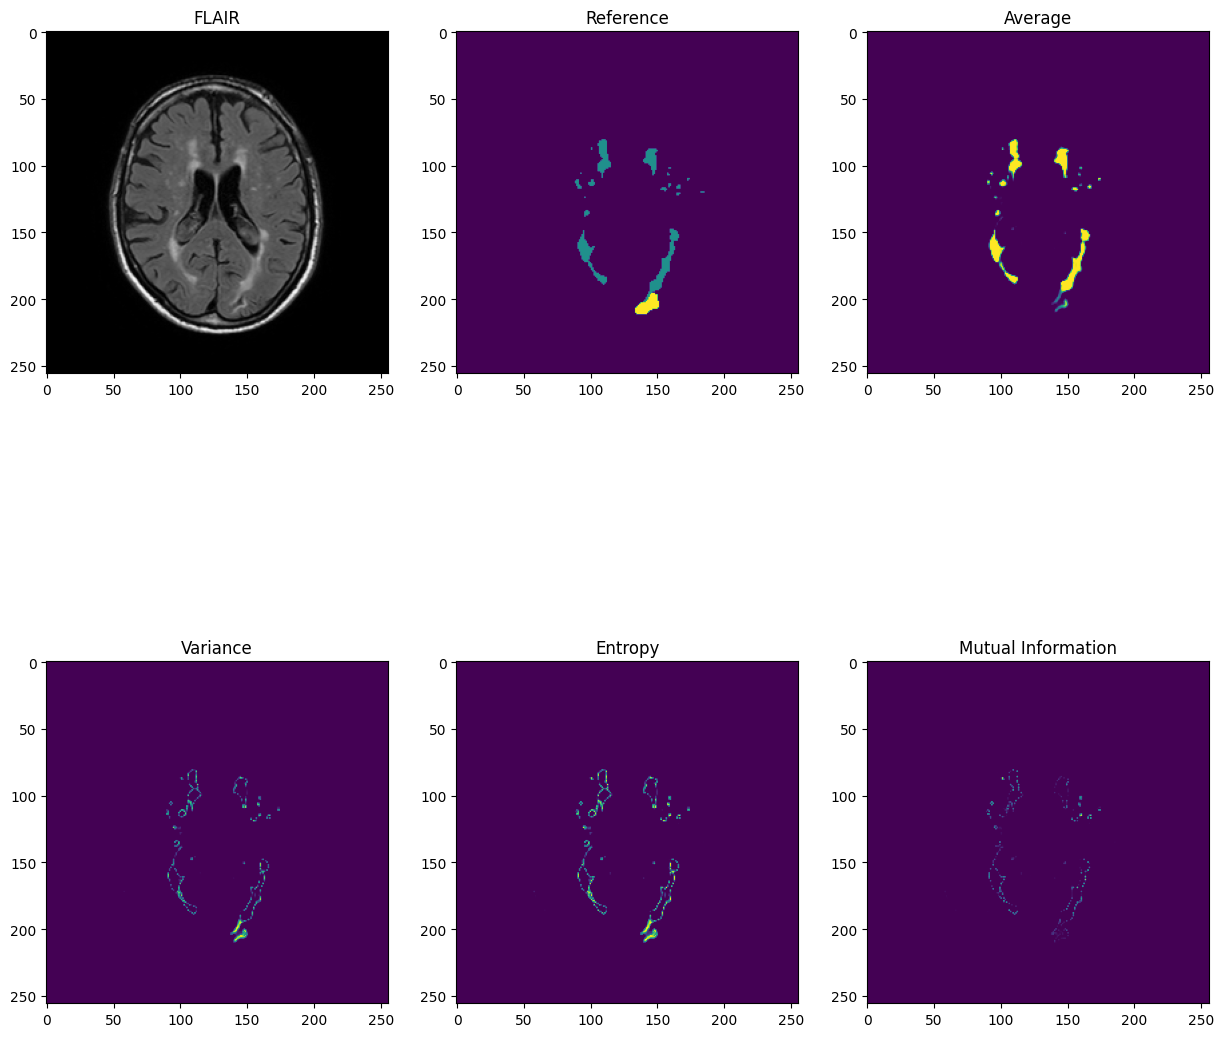

In [ ]:
fig, axes = plt.subplots(2,3,figsize=(15,15))

img = nib.load(glob.glob('Img/*41*')[0]).get_fdata()[12,:,:].T
ref = nib.load(glob.glob('Ref/*41*')[0]).get_fdata()[12,:,:].T
ave = nib.load(glob.glob('UncertaintyEnsembling/Average*41*')[0]).get_fdata()[12,:,:].T
var = nib.load(glob.glob('UncertaintyEnsembling/Variance*41*')[0]).get_fdata()[12,:,:].T
ent = nib.load(glob.glob('UncertaintyEnsembling/Entropy*41*')[0]).get_fdata()[12,:,:].T
mi = nib.load(glob.glob('UncertaintyEnsembling/MI*41*')[0]).get_fdata()[12,:,:].T

ent = np.where(np.isnan(ent),np.zeros_like(ent),ent)
mi = np.where(np.isnan(mi),np.zeros_like(mi),mi)

axes[0,0].imshow(img*-1,cmap='Greys')
axes[0,0].set_title('FLAIR')
axes[0,1].imshow(ref)
axes[0,1].set_title('Reference')
axes[0,2].imshow(ave)
axes[0,2].set_title('Average')
axes[1,0].imshow(var)
axes[1,0].set_title('Variance')
axes[1,1].imshow(ent,vmin=0)
axes[1,1].set_title('Entropy')
axes[1,2].imshow(mi,vmin=0)
axes[1,2].set_title('Mutual Information')

# PART 2: Test time augmentation



In [ ]:
transforms_aug = [torchio.CropOrPad(target_shape=[256,256,1]),
              torchio.RandomMotion(),
              torchio.RandomGhosting(num_ghosts=5),
              torchio.RandomBiasField(),
              torchio.RandomBlur(),
    torchio.RescaleIntensity(out_min_max=(0, 1))
]
transform_aug = torchio.Compose(transforms_aug)


target_dataset_aug = torchio.SubjectsDataset(target_validation_subjects, transform=transform_aug)
target_aug_loader = DataLoader(target_dataset_validation, shuffle=False, batch_size=6)


In [ ]:
list_dsc_aug = []
for k in range(1,60):
    list_dice = inference(model1,target_aug_loader,batch_size=6,slices_per_image=24, model_name='modelAug%d'%k)
    list_dsc_aug.append(list_dice)

  0%|                                                                                                                                                                                | 0/69 [00:00<?, ?it/s]<built-in method size of Tensor object at 0x29d57f290>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_100_predmodelAug1.nii.gz
tensor(966.) tensor(1063.) tensor(1767.)
<built-in method size of Tensor object at 0x29d57ea50>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_101_predmodelAug1.nii.gz
tensor(490.) tensor(644.) tensor(881.)
<built-in method size of Tensor object at 0x29d531d90>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_102_predmodelAug1.nii.gz
tensor(606.) tensor(692.) tensor(1183.)
<built-in method size of Tensor object at 0x29d531070>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_103_predmodelAug1.nii.gz
tensor(4726.) tensor(4924.) tensor(6401.)
<built-in method size of Tensor object at 0x29d5302f0>
Calculating

tensor(2509.) tensor(2832.) tensor(3252.)
<built-in method size of Tensor object at 0x29d59f530>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_106_predmodelAug3.nii.gz
tensor(547.) tensor(583.) tensor(861.)
<built-in method size of Tensor object at 0x29d59c950>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_50_predmodelAug3.nii.gz
tensor(6180.) tensor(6450.) tensor(8561.)
<built-in method size of Tensor object at 0x29d587a70>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_51_predmodelAug3.nii.gz
tensor(6570.) tensor(6755.) tensor(8849.)
<built-in method size of Tensor object at 0x29d598c50>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_52_predmodelAug3.nii.gz
tensor(1281.) tensor(1495.) tensor(1648.)
<built-in method size of Tensor object at 0x29d59f770>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_53_predmodelAug3.nii.gz
tensor(207.) tensor(353.) tensor(381.)
<built-in method size of Tensor object at 0x29d5

tensor(9549.) tensor(11125.) tensor(11256.)
<built-in method size of Tensor object at 0x29d59f650>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_6_predmodelAug5.nii.gz
tensor(317.) tensor(417.) tensor(678.)
<built-in method size of Tensor object at 0x29d598470>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_8_predmodelAug5.nii.gz
tensor(304.) tensor(552.) tensor(544.)
<built-in method size of Tensor object at 0x29d599b50>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_41_predmodelAug5.nii.gz
tensor(10124.) tensor(10706.) tensor(11998.)
<built-in method size of Tensor object at 0x29d59f470>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_49_predmodelAug5.nii.gz
tensor(6861.) tensor(7284.) tensor(9570.)
  0%|                                                                                                                                                                                | 0/69 [00:00<?, ?it/s]<built-in method size of Tensor o

tensor(969.) tensor(1068.) tensor(1767.)
<built-in method size of Tensor object at 0x29d59fd70>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_101_predmodelAug8.nii.gz
tensor(495.) tensor(655.) tensor(881.)
<built-in method size of Tensor object at 0x29d598a70>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_102_predmodelAug8.nii.gz
tensor(614.) tensor(700.) tensor(1183.)
<built-in method size of Tensor object at 0x29d585370>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_103_predmodelAug8.nii.gz
tensor(4686.) tensor(4876.) tensor(6401.)
<built-in method size of Tensor object at 0x29d59fa10>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_104_predmodelAug8.nii.gz
tensor(6572.) tensor(7191.) tensor(8079.)
<built-in method size of Tensor object at 0x29d59d670>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_105_predmodelAug8.nii.gz
tensor(2531.) tensor(2873.) tensor(3252.)
<built-in method size of Tensor object at 0x

tensor(6152.) tensor(6405.) tensor(8561.)
<built-in method size of Tensor object at 0x29d59e750>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_51_predmodelAug10.nii.gz
tensor(6516.) tensor(6721.) tensor(8849.)
<built-in method size of Tensor object at 0x29d59d730>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_52_predmodelAug10.nii.gz
tensor(1282.) tensor(1502.) tensor(1648.)
<built-in method size of Tensor object at 0x29d58ea50>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_53_predmodelAug10.nii.gz
tensor(205.) tensor(369.) tensor(381.)
<built-in method size of Tensor object at 0x29d57bdd0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_54_predmodelAug10.nii.gz
tensor(125.) tensor(189.) tensor(256.)
<built-in method size of Tensor object at 0x29d58ec90>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_4_predmodelAug10.nii.gz
tensor(9498.) tensor(11073.) tensor(11256.)
<built-in method size of Tensor object at 0x2

tensor(296.) tensor(543.) tensor(544.)
<built-in method size of Tensor object at 0x29d59d850>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_41_predmodelAug12.nii.gz
tensor(10144.) tensor(10705.) tensor(11998.)
<built-in method size of Tensor object at 0x29d59e4b0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_49_predmodelAug12.nii.gz
tensor(6988.) tensor(7408.) tensor(9570.)
  0%|                                                                                                                                                                                | 0/69 [00:00<?, ?it/s]<built-in method size of Tensor object at 0x29d57a3f0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_100_predmodelAug13.nii.gz
tensor(986.) tensor(1094.) tensor(1767.)
<built-in method size of Tensor object at 0x29d59ce90>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_101_predmodelAug13.nii.gz
tensor(493.) tensor(653.) tensor(881.)
<built-in method size of

<built-in method size of Tensor object at 0x29d599b50>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_102_predmodelAug15.nii.gz
tensor(612.) tensor(679.) tensor(1183.)
<built-in method size of Tensor object at 0x29d59cd70>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_103_predmodelAug15.nii.gz
tensor(4714.) tensor(4922.) tensor(6401.)
<built-in method size of Tensor object at 0x29d59b950>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_104_predmodelAug15.nii.gz
tensor(6554.) tensor(7177.) tensor(8079.)
<built-in method size of Tensor object at 0x29d59f770>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_105_predmodelAug15.nii.gz
tensor(2527.) tensor(2865.) tensor(3252.)
<built-in method size of Tensor object at 0x29d59f230>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_106_predmodelAug15.nii.gz
tensor(570.) tensor(604.) tensor(861.)
<built-in method size of Tensor object at 0x29d5996d0>
Calculating dice torch.Si

tensor(6488.) tensor(6669.) tensor(8849.)
<built-in method size of Tensor object at 0x29d59b6b0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_52_predmodelAug17.nii.gz
tensor(1301.) tensor(1534.) tensor(1648.)
<built-in method size of Tensor object at 0x29d59f350>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_53_predmodelAug17.nii.gz
tensor(208.) tensor(369.) tensor(381.)
<built-in method size of Tensor object at 0x29d59c710>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_54_predmodelAug17.nii.gz
tensor(125.) tensor(178.) tensor(256.)
<built-in method size of Tensor object at 0x29d59ce90>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_4_predmodelAug17.nii.gz
tensor(9448.) tensor(10979.) tensor(11256.)
<built-in method size of Tensor object at 0x29d59ebd0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_6_predmodelAug17.nii.gz
tensor(310.) tensor(405.) tensor(678.)
<built-in method size of Tensor object at 0x29d59d6

tensor(10113.) tensor(10712.) tensor(11998.)
<built-in method size of Tensor object at 0x29d585370>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_49_predmodelAug19.nii.gz
tensor(6898.) tensor(7312.) tensor(9570.)
  0%|                                                                                                                                                                                | 0/69 [00:00<?, ?it/s]<built-in method size of Tensor object at 0x29d59fb90>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_100_predmodelAug20.nii.gz
tensor(983.) tensor(1077.) tensor(1767.)
<built-in method size of Tensor object at 0x29d598170>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_101_predmodelAug20.nii.gz
tensor(523.) tensor(676.) tensor(881.)
<built-in method size of Tensor object at 0x29d59ce90>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_102_predmodelAug20.nii.gz
tensor(621.) tensor(699.) tensor(1183.)
<built-in method siz

<built-in method size of Tensor object at 0x29d59f950>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_103_predmodelAug22.nii.gz
tensor(4751.) tensor(4961.) tensor(6401.)
<built-in method size of Tensor object at 0x29d59ebd0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_104_predmodelAug22.nii.gz
tensor(6606.) tensor(7226.) tensor(8079.)
<built-in method size of Tensor object at 0x29d59e270>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_105_predmodelAug22.nii.gz
tensor(2500.) tensor(2844.) tensor(3252.)
<built-in method size of Tensor object at 0x29d59dc70>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_106_predmodelAug22.nii.gz
tensor(576.) tensor(616.) tensor(861.)
<built-in method size of Tensor object at 0x29d59a030>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_50_predmodelAug22.nii.gz
tensor(6187.) tensor(6446.) tensor(8561.)
<built-in method size of Tensor object at 0x29d599b50>
Calculating dice torch.S

tensor(1276.) tensor(1511.) tensor(1648.)
<built-in method size of Tensor object at 0x29d59c950>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_53_predmodelAug24.nii.gz
tensor(198.) tensor(354.) tensor(381.)
<built-in method size of Tensor object at 0x29d59d430>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_54_predmodelAug24.nii.gz
tensor(126.) tensor(190.) tensor(256.)
<built-in method size of Tensor object at 0x29d59de50>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_4_predmodelAug24.nii.gz
tensor(9544.) tensor(11131.) tensor(11256.)
<built-in method size of Tensor object at 0x29d59f470>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_6_predmodelAug24.nii.gz
tensor(319.) tensor(426.) tensor(678.)
<built-in method size of Tensor object at 0x29d59a3f0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_8_predmodelAug24.nii.gz
tensor(296.) tensor(557.) tensor(544.)
<built-in method size of Tensor object at 0x29d59d4f0>
Ca

tensor(6920.) tensor(7358.) tensor(9570.)
  0%|                                                                                                                                                                                | 0/69 [00:00<?, ?it/s]<built-in method size of Tensor object at 0x29d59e330>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_100_predmodelAug27.nii.gz
tensor(983.) tensor(1082.) tensor(1767.)
<built-in method size of Tensor object at 0x29d530350>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_101_predmodelAug27.nii.gz
tensor(512.) tensor(673.) tensor(881.)
<built-in method size of Tensor object at 0x29d58f230>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_102_predmodelAug27.nii.gz
tensor(614.) tensor(695.) tensor(1183.)
<built-in method size of Tensor object at 0x29d58e870>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_103_predmodelAug27.nii.gz
tensor(4706.) tensor(4921.) tensor(6401.)
<built-in method siz

<built-in method size of Tensor object at 0x29d59db50>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_104_predmodelAug29.nii.gz
tensor(6551.) tensor(7128.) tensor(8079.)
<built-in method size of Tensor object at 0x29d59f4d0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_105_predmodelAug29.nii.gz
tensor(2483.) tensor(2818.) tensor(3252.)
<built-in method size of Tensor object at 0x29d57c650>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_106_predmodelAug29.nii.gz
tensor(549.) tensor(587.) tensor(861.)
<built-in method size of Tensor object at 0x29d5998b0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_50_predmodelAug29.nii.gz
tensor(6160.) tensor(6408.) tensor(8561.)
<built-in method size of Tensor object at 0x29d599d90>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_51_predmodelAug29.nii.gz
tensor(6523.) tensor(6707.) tensor(8849.)
<built-in method size of Tensor object at 0x29d59f350>
Calculating dice torch.Si

tensor(202.) tensor(355.) tensor(381.)
<built-in method size of Tensor object at 0x29d599430>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_54_predmodelAug31.nii.gz
tensor(130.) tensor(189.) tensor(256.)
<built-in method size of Tensor object at 0x29d59d430>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_4_predmodelAug31.nii.gz
tensor(9480.) tensor(11070.) tensor(11256.)
<built-in method size of Tensor object at 0x29d530350>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_6_predmodelAug31.nii.gz
tensor(323.) tensor(422.) tensor(678.)
<built-in method size of Tensor object at 0x29d59d4f0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_8_predmodelAug31.nii.gz
tensor(299.) tensor(571.) tensor(544.)
<built-in method size of Tensor object at 0x29d5867b0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_41_predmodelAug31.nii.gz
tensor(10111.) tensor(10671.) tensor(11998.)
<built-in method size of Tensor object at 0x29d58c8f0>
C

  0%|                                                                                                                                                                                | 0/69 [00:00<?, ?it/s]<built-in method size of Tensor object at 0x29d55b470>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_100_predmodelAug34.nii.gz
tensor(968.) tensor(1063.) tensor(1767.)
<built-in method size of Tensor object at 0x29d5996d0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_101_predmodelAug34.nii.gz
tensor(500.) tensor(650.) tensor(881.)
<built-in method size of Tensor object at 0x29d59d430>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_102_predmodelAug34.nii.gz
tensor(604.) tensor(678.) tensor(1183.)
<built-in method size of Tensor object at 0x29d5996d0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_103_predmodelAug34.nii.gz
tensor(4718.) tensor(4931.) tensor(6401.)
<built-in method size of Tensor object at 0x29d5847d0>
Calcula

tensor(6551.) tensor(7199.) tensor(8079.)
<built-in method size of Tensor object at 0x29d59cad0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_105_predmodelAug36.nii.gz
tensor(2525.) tensor(2866.) tensor(3252.)
<built-in method size of Tensor object at 0x29d59d970>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_106_predmodelAug36.nii.gz
tensor(565.) tensor(602.) tensor(861.)
<built-in method size of Tensor object at 0x29d5998b0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_50_predmodelAug36.nii.gz
tensor(6232.) tensor(6488.) tensor(8561.)
<built-in method size of Tensor object at 0x29d59a6f0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_51_predmodelAug36.nii.gz
tensor(6534.) tensor(6724.) tensor(8849.)
<built-in method size of Tensor object at 0x29d59f710>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_52_predmodelAug36.nii.gz
tensor(1285.) tensor(1523.) tensor(1648.)
<built-in method size of Tensor object 

tensor(124.) tensor(178.) tensor(256.)
<built-in method size of Tensor object at 0x29d59f590>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_4_predmodelAug38.nii.gz
tensor(9540.) tensor(11111.) tensor(11256.)
<built-in method size of Tensor object at 0x29d59cad0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_6_predmodelAug38.nii.gz
tensor(311.) tensor(409.) tensor(678.)
<built-in method size of Tensor object at 0x29d598c50>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_8_predmodelAug38.nii.gz
tensor(297.) tensor(540.) tensor(544.)
<built-in method size of Tensor object at 0x29d59e210>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_41_predmodelAug38.nii.gz
tensor(10064.) tensor(10624.) tensor(11998.)
<built-in method size of Tensor object at 0x29d59a030>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_49_predmodelAug38.nii.gz
tensor(6922.) tensor(7376.) tensor(9570.)
  0%|                                                  

  0%|                                                                                                                                                                                | 0/69 [00:00<?, ?it/s]<built-in method size of Tensor object at 0x29d55aed0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_100_predmodelAug41.nii.gz
tensor(980.) tensor(1075.) tensor(1767.)
<built-in method size of Tensor object at 0x29d599c10>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_101_predmodelAug41.nii.gz
tensor(492.) tensor(659.) tensor(881.)
<built-in method size of Tensor object at 0x29d59db50>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_102_predmodelAug41.nii.gz
tensor(613.) tensor(693.) tensor(1183.)
<built-in method size of Tensor object at 0x29d57a3f0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_103_predmodelAug41.nii.gz
tensor(4693.) tensor(4914.) tensor(6401.)
<built-in method size of Tensor object at 0x29d5998b0>
Calcula

tensor(2503.) tensor(2815.) tensor(3252.)
<built-in method size of Tensor object at 0x29d57bdd0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_106_predmodelAug43.nii.gz
tensor(551.) tensor(593.) tensor(861.)
<built-in method size of Tensor object at 0x29d59f5f0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_50_predmodelAug43.nii.gz
tensor(6191.) tensor(6462.) tensor(8561.)
<built-in method size of Tensor object at 0x29d578d70>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_51_predmodelAug43.nii.gz
tensor(6538.) tensor(6710.) tensor(8849.)
<built-in method size of Tensor object at 0x29d55aed0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_52_predmodelAug43.nii.gz
tensor(1282.) tensor(1511.) tensor(1648.)
<built-in method size of Tensor object at 0x29d5998b0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_53_predmodelAug43.nii.gz
tensor(205.) tensor(353.) tensor(381.)
<built-in method size of Tensor object at 0

tensor(9548.) tensor(11140.) tensor(11256.)
<built-in method size of Tensor object at 0x29d586b10>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_6_predmodelAug45.nii.gz
tensor(311.) tensor(410.) tensor(678.)
<built-in method size of Tensor object at 0x29d59cad0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_8_predmodelAug45.nii.gz
tensor(299.) tensor(577.) tensor(544.)
<built-in method size of Tensor object at 0x29d59f2f0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_41_predmodelAug45.nii.gz
tensor(10119.) tensor(10733.) tensor(11998.)
<built-in method size of Tensor object at 0x29d58fd70>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_49_predmodelAug45.nii.gz
tensor(6948.) tensor(7375.) tensor(9570.)
  0%|                                                                                                                                                                                | 0/69 [00:00<?, ?it/s]<built-in method size of Tens

  0%|                                                                                                                                                                                | 0/69 [00:00<?, ?it/s]<built-in method size of Tensor object at 0x29d59fb90>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_100_predmodelAug48.nii.gz
tensor(983.) tensor(1090.) tensor(1767.)
<built-in method size of Tensor object at 0x29d598a70>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_101_predmodelAug48.nii.gz
tensor(498.) tensor(658.) tensor(881.)
<built-in method size of Tensor object at 0x29d59ecf0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_102_predmodelAug48.nii.gz
tensor(624.) tensor(695.) tensor(1183.)
<built-in method size of Tensor object at 0x29d58e3f0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_103_predmodelAug48.nii.gz
tensor(4777.) tensor(4992.) tensor(6401.)
<built-in method size of Tensor object at 0x29d59c710>
Calcula

<built-in method size of Tensor object at 0x29d59fb90>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_103_predmodelAug50.nii.gz
tensor(4683.) tensor(4887.) tensor(6401.)
<built-in method size of Tensor object at 0x29d59c230>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_104_predmodelAug50.nii.gz
tensor(6550.) tensor(7167.) tensor(8079.)
<built-in method size of Tensor object at 0x29d59d5b0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_105_predmodelAug50.nii.gz
tensor(2492.) tensor(2827.) tensor(3252.)
<built-in method size of Tensor object at 0x29d59ae10>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_106_predmodelAug50.nii.gz
tensor(555.) tensor(595.) tensor(861.)
<built-in method size of Tensor object at 0x29d530350>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_50_predmodelAug50.nii.gz
tensor(6261.) tensor(6530.) tensor(8561.)
<built-in method size of Tensor object at 0x29d59c8f0>
Calculating dice torch.S

<built-in method size of Tensor object at 0x29d598770>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_106_predmodelAug52.nii.gz
tensor(562.) tensor(604.) tensor(861.)
<built-in method size of Tensor object at 0x29d59f050>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_50_predmodelAug52.nii.gz
tensor(6216.) tensor(6494.) tensor(8561.)
<built-in method size of Tensor object at 0x29d57bcb0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_51_predmodelAug52.nii.gz
tensor(6541.) tensor(6744.) tensor(8849.)
<built-in method size of Tensor object at 0x29d59d490>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_52_predmodelAug52.nii.gz
tensor(1285.) tensor(1504.) tensor(1648.)
<built-in method size of Tensor object at 0x29d55bb30>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_53_predmodelAug52.nii.gz
tensor(202.) tensor(355.) tensor(381.)
<built-in method size of Tensor object at 0x29d59d490>
Calculating dice torch.Size([2

<built-in method size of Tensor object at 0x29d5998b0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_52_predmodelAug54.nii.gz
tensor(1291.) tensor(1520.) tensor(1648.)
<built-in method size of Tensor object at 0x29d55aed0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_53_predmodelAug54.nii.gz
tensor(209.) tensor(356.) tensor(381.)
<built-in method size of Tensor object at 0x29d59e870>
Calculating dice torch.Size([24, 1, 256, 256]) for  Singapore_54_predmodelAug54.nii.gz
tensor(121.) tensor(184.) tensor(256.)
<built-in method size of Tensor object at 0x29d59f4d0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_4_predmodelAug54.nii.gz
tensor(9489.) tensor(11067.) tensor(11256.)
<built-in method size of Tensor object at 0x29d59f4d0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_6_predmodelAug54.nii.gz
tensor(314.) tensor(412.) tensor(678.)
<built-in method size of Tensor object at 0x29d59be90>
Calculating dice torch.Size([24, 1, 25

<built-in method size of Tensor object at 0x29d530350>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_4_predmodelAug56.nii.gz
tensor(9494.) tensor(11098.) tensor(11256.)
<built-in method size of Tensor object at 0x29d59f950>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_6_predmodelAug56.nii.gz
tensor(320.) tensor(424.) tensor(678.)
<built-in method size of Tensor object at 0x29d57be30>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_8_predmodelAug56.nii.gz
tensor(301.) tensor(565.) tensor(544.)
<built-in method size of Tensor object at 0x29d59fa70>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_41_predmodelAug56.nii.gz
tensor(10156.) tensor(10736.) tensor(11998.)
<built-in method size of Tensor object at 0x29d59dc70>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_49_predmodelAug56.nii.gz
tensor(6960.) tensor(7410.) tensor(9570.)
  0%|                                                                                         

<built-in method size of Tensor object at 0x29d59c8f0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_41_predmodelAug58.nii.gz
tensor(10153.) tensor(10722.) tensor(11998.)
<built-in method size of Tensor object at 0x29d57bad0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Utrecht_49_predmodelAug58.nii.gz
tensor(6839.) tensor(7253.) tensor(9570.)
  0%|                                                                                                                                                                                                                                                                                                                                                | 0/69 [00:00<?, ?it/s]<built-in method size of Tensor object at 0x29d55b3b0>
Calculating dice torch.Size([24, 1, 256, 256]) for  Amsterdam_100_predmodelAug59.nii.gz
tensor(983.) tensor(1076.) tensor(1767.)
<built-in method size of Tensor object at 0x29d532270>
Calculating dice torch.Size([2

In [ ]:
df_dsc_aug = pd.DataFrame(list_dsc_aug)
df_dsc_aug.to_csv('DSCAug.csv')
df_dsc_aug.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
count,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000
mean,0.687702,0.646698,0.657244,0.832044,0.861032,0.822978,0.771375,0.824464,0.837484,0.814354,0.558562,0.558412,0.851994,0.582385,0.543415,0.892642,0.818375
std,0.004487,0.008377,0.005167,0.002901,0.001958,0.003126,0.008693,0.002776,0.002266,0.003478,0.008948,0.017165,0.001602,0.008600,0.006385,0.001653,0.002416
min,0.677534,0.626395,0.646400,0.825211,0.856143,0.815650,0.754144,0.818364,0.832990,0.807851,0.534413,0.519362,0.847972,0.561694,0.532491,0.889212,0.813054
25%,0.684164,0.642857,0.653301,0.829896,0.859569,0.820189,0.765449,0.822088,0.836079,0.811640,0.553391,0.549336,0.851265,0.576287,0.539295,0.891408,0.816529
50%,0.688073,0.646636,0.657432,0.831945,0.861375,0.823337,0.770705,0.824657,0.837227,0.813688,0.558630,0.558352,0.852074,0.583333,0.543143,0.892694,0.818369
75%,0.691254,0.650001,0.660117,0.833819,0.862182,0.825673,0.778947,0.826038,0.838960,0.817016,0.564624,0.569790,0.852963,0.588235,0.547619,0.893716,0.820130
max,0.695986,0.671805,0.667372,0.838602,0.866480,0.827992,0.790792,0.831556,0.842092,0.821406,0.577236,0.595455,0.855771,0.604444,0.561983,0.896437,0.823183


In [ ]:
pred_list = sorted(glob.glob('OutputsTTA/*pred*modelAug1.nii.gz'))
for k in pred_list:
    name_last = k.split('/')[1]
    name_split = name_last.split('_')
    name = name_split[0]+'_'+name_split[1]
    list_images = sorted(glob.glob('OutputsTTA/'+name+'*pred*.nii.gz'))
    stack = create_stack(list_images)
    create_average(stack,'UncertaintyTTA/Average_'+name+'.nii.gz')
    create_variance(stack,'UncertaintyTTA/Variance_'+name+'.nii.gz')
    create_mi(stack,'UncertaintyTTA/MI_'+name+'.nii.gz')
    create_entropy(stack,'UncertaintyTTA/Entropy_'+name+'.nii.gz')
    print('Done for ',name)

/var/folders/9x/f7zq7s_d1fv5z99dsps_gk2m0000gn/T/ipykernel_4974/1691701407.py:2: RuntimeWarning: divide by zero encountered in log
  stacked_entropy = stacked_image * np.log(stacked_image) + (1-stacked_image)*np.log(1-stacked_image)
/var/folders/9x/f7zq7s_d1fv5z99dsps_gk2m0000gn/T/ipykernel_4974/1691701407.py:2: RuntimeWarning: invalid value encountered in multiply
  stacked_entropy = stacked_image * np.log(stacked_image) + (1-stacked_image)*np.log(1-stacked_image)
/var/folders/9x/f7zq7s_d1fv5z99dsps_gk2m0000gn/T/ipykernel_4974/1878054677.py:3: RuntimeWarning: divide by zero encountered in log
  entropy = average *np.log(average) + (1-average)*np.log(1-average)
/var/folders/9x/f7zq7s_d1fv5z99dsps_gk2m0000gn/T/ipykernel_4974/1878054677.py:3: RuntimeWarning: invalid value encountered in multiply
  entropy = average *np.log(average) + (1-average)*np.log(1-average)


Done for  Amsterdam_100
Done for  Amsterdam_101
Done for  Amsterdam_102
Done for  Amsterdam_103
Done for  Amsterdam_104
Done for  Amsterdam_105
Done for  Amsterdam_106
Done for  Singapore_50
Done for  Singapore_51
Done for  Singapore_52
Done for  Singapore_53
Done for  Singapore_54
Done for  Utrecht_41
Done for  Utrecht_49
Done for  Utrecht_4
Done for  Utrecht_6
Done for  Utrecht_8


Text(0.5, 1.0, 'Mutual Information')

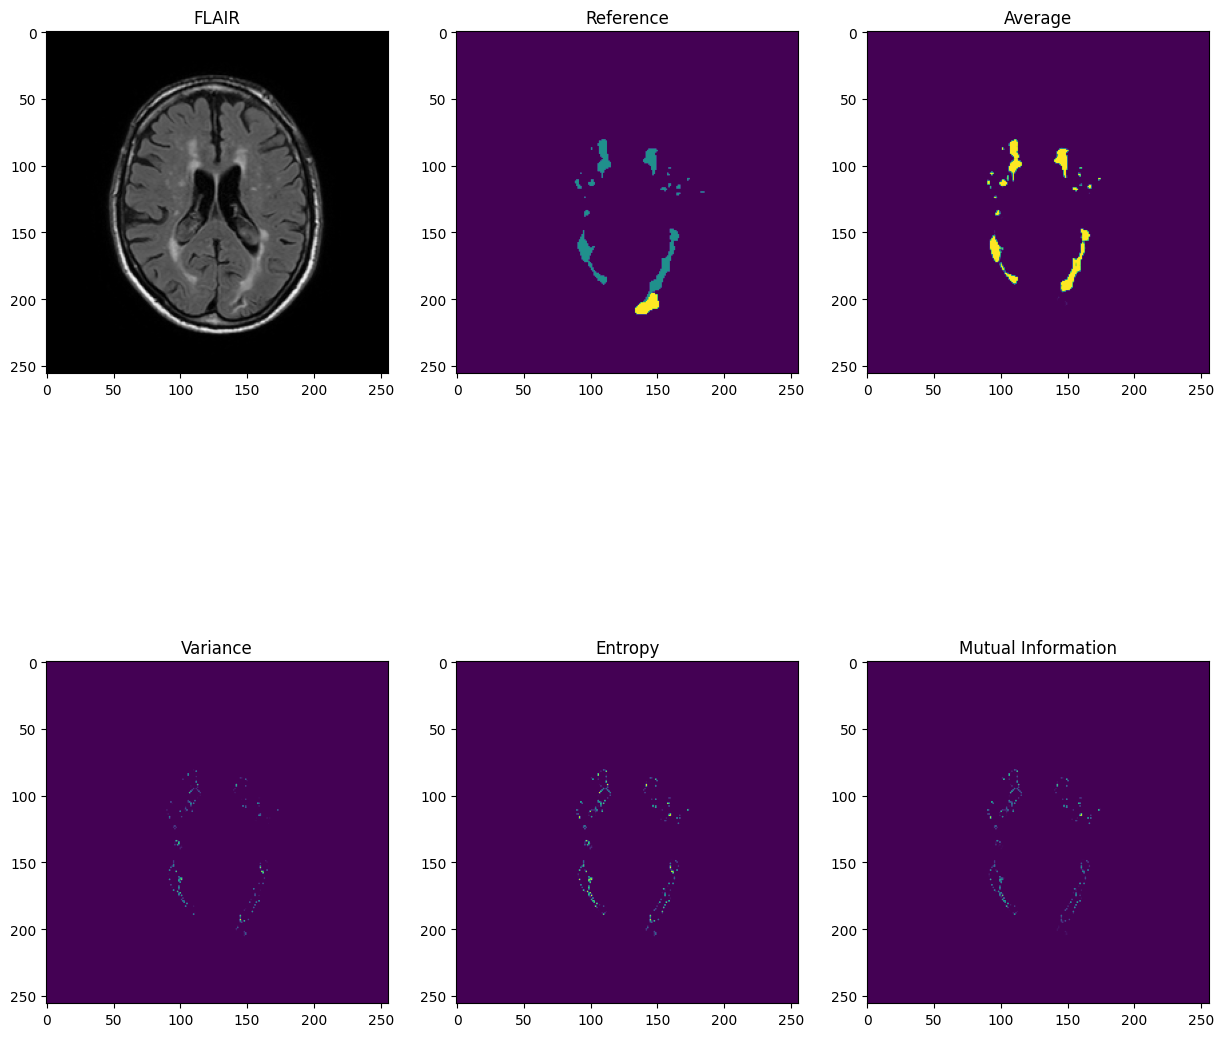

In [ ]:
fig, axes = plt.subplots(2,3,figsize=(15,15))

img = nib.load(glob.glob('Img/*41*')[0]).get_fdata()[12,:,:].T
ref = nib.load(glob.glob('Ref/*41*')[0]).get_fdata()[12,:,:].T
ave = nib.load(glob.glob('UncertaintyTTA/Average*41*')[0]).get_fdata()[12,:,:].T
var = nib.load(glob.glob('UncertaintyTTA/Variance*41*')[0]).get_fdata()[12,:,:].T
ent = nib.load(glob.glob('UncertaintyTTA/Entropy*41*')[0]).get_fdata()[12,:,:].T
mi = nib.load(glob.glob('UncertaintyTTA/MI*41*')[0]).get_fdata()[12,:,:].T

ent = np.where(np.isnan(ent),np.zeros_like(ent),ent)
mi = np.where(np.isnan(mi),np.zeros_like(mi),mi)

axes[0,0].imshow(img*-1,cmap='Greys')
axes[0,0].set_title('FLAIR')
axes[0,1].imshow(ref)
axes[0,1].set_title('Reference')
axes[0,2].imshow(ave)
axes[0,2].set_title('Average')
axes[1,0].imshow(var)
axes[1,0].set_title('Variance')
axes[1,1].imshow(ent,vmin=0)
axes[1,1].set_title('Entropy')
axes[1,2].imshow(mi,vmin=0)
axes[1,2].set_title('Mutual Information')

In [ ]:
# Part 3 - Conformal predictions


In [ ]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder as LE
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
import sys
import time
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import confusion_matrix as cm
from sklearn.preprocessing import OneHotEncoder as OHE

In [ ]:
df_adni = pd.read_csv('ADNI/ADNIMERGE.csv')
df_adni = df_adni.sort_values('EXAMDATE').drop_duplicates('RID')
df_adni['SEX'] = np.where(df_adni['PTGENDER']=='Female',1,0)
df_adnia = df_adni.dropna(subset=['DX_bl','SEX','AGE','Hippocampus_bl','MMSE_bl','ICV_bl'])
le = LE()
diag = le.fit_transform(df_adnia['DX_bl'])
df_adnia['diagnosis'] = diag

/var/folders/9x/f7zq7s_d1fv5z99dsps_gk2m0000gn/T/ipykernel_4974/3545597063.py:1: DtypeWarning: Columns (19,20,21,50,51,104,105,106) have mixed types. Specify dtype option on import or set low_memory=False.
  df_adni = pd.read_csv('ADNI/ADNIMERGE.csv')
/var/folders/9x/f7zq7s_d1fv5z99dsps_gk2m0000gn/T/ipykernel_4974/3545597063.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_adnia['diagnosis'] = diag


In [ ]:
class DatasetADNI(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, dataframe, list_values):
        'Initialization'
        self.labels = np.asarray(dataframe['diagnosis'])
        self.list_IDs = np.asarray(dataframe['RID'])
        self.list_values = list_values
        self.dataframe = dataframe

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        X = np.asarray(self.dataframe.iloc[index][self.list_values])
        y = self.labels[index]
        sample = {'data': X, 'label': y}

        return sample

In [ ]:
valid = df_adnia.sample(frac=0.1, replace=False)
remain = df_adnia.drop(valid.index)
test = remain.sample(frac=0.2, replace=False)
train = remain.drop(test.index)

In [ ]:
MMS = MinMaxScaler()
train_mms = MMS.fit_transform(train[['Hippocampus_bl','ICV_bl','AGE','MMSE_bl']])
MMS.fit(train[['Hippocampus_bl','ICV_bl','AGE','MMSE_bl']])

MinMaxScaler()

In [ ]:
test_mms = MMS.transform(test[['Hippocampus_bl','ICV_bl','AGE','MMSE_bl']])
valid_mms = MMS.transform(valid[['Hippocampus_bl','ICV_bl','AGE','MMSE_bl']])

In [ ]:
dict_data = {'RID': train['RID'],'diagnosis': train['diagnosis'], 'sex': train['SEX'], 'hipp':train_mms[:,0], 'icv': train_mms[:,1],'age':train_mms[:,2], 'mmse': train_mms[:,3]}
df_train = pd.DataFrame(dict_data)

In [ ]:
dict_data = {'RID': test['RID'],'diagnosis': test['diagnosis'], 'sex': test['SEX'], 'hipp':test_mms[:,0], 'icv': test_mms[:,1],'age':test_mms[:,2], 'mmse': test_mms[:,3]}
df_test = pd.DataFrame(dict_data)

In [ ]:
dict_data = {'RID': valid['RID'],'diagnosis': valid['diagnosis'], 'sex': valid['SEX'], 'hipp':valid_mms[:,0], 'icv': valid_mms[:,1],'age':valid_mms[:,2], 'mmse': valid_mms[:,3]}
df_valid = pd.DataFrame(dict_data)

In [ ]:
list_feat = ['sex','hipp','age','icv','mmse']

In [ ]:
dataset = DatasetADNI(df_train, ['hipp','icv','age','mmse','sex'])

In [ ]:
def initialize_weights(*models):
    for model in models:
        for module in model.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                nn.init.kaiming_normal(module.weight)
                if module.bias is not None:
                    module.bias.data.zero_()
            elif isinstance(module, nn.BatchNorm2d):
                module.weight.data.fill_(1)
                module.bias.data.zero_()

In [ ]:

class MultiFCn(nn.Module):
    def __init__(self, num_classes, num_channels):
        super(MultiFCn, self).__init__()
        self.fc1 = nn.Linear(num_channels, 16)
        self.fc2 = nn.Linear(16,32)
        self.fc3 = nn.Linear(32, num_classes)
        initialize_weights(self)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        return x

In [ ]:
dataloader = DataLoader(dataset, shuffle=True, batch_size=20)

In [ ]:
dataset_test = DatasetADNI(df_test, ['hipp','icv','age','mmse','sex'])
dataset_valid = DatasetADNI(df_valid, ['hipp','icv','age','mmse','sex'])
testloader = DataLoader(dataset_test, shuffle=False, batch_size=20)
validloader = DataLoader(dataset_valid, shuffle=False, batch_size=20)

In [ ]:

def cross_entropy(pred, label, weight=None, reduction='mean',
                  avg_factor=None):
    # element-wise losses
    # print((pred[:,:]*weight).sum(), label.sum(), pred.shape)
    loss = F.cross_entropy(pred, label.type(torch.LongTensor), reduction=reduction)

    # apply weights and do the reduction
    if weight is not None:
        weight = weight.float()
        loss = (loss * weight).sum()/weight.sum()

    return loss

/var/folders/9x/f7zq7s_d1fv5z99dsps_gk2m0000gn/T/ipykernel_4974/659818287.py:5: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(module.weight)


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                      | 44/75 [00:00<00:00, 431.77it/s]Epoch  10  Loss  1.5742873191833495


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 424.38it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                      | 44/75 [00:00<00:00, 433.48it/s]Epoch  31  Loss  1.5191884994506837


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 435.51it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                      | 44/75 [00:00<00:00, 434.70it/s]Epoch  52  Loss  1.5052632093429565


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 432.79it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                               | 42/75 [00:00<00:00, 414.65it/s]Epoch  73  Loss  1.3802116155624389


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 439.58it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 45/75 [00:00<00:00, 447.17it/s]Epoch  94  Loss  1.3318923115730286


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 441.67it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 45/75 [00:00<00:00, 449.13it/s]Epoch  115  Loss  1.4085224509239196


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 448.87it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 45/75 [00:00<00:00, 447.30it/s]Epoch  136  Loss  1.3315151691436768


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 449.27it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 45/75 [00:00<00:00, 448.32it/s]Epoch  157  Loss  1.3140272140502929


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 448.55it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 45/75 [00:00<00:00, 449.95it/s]Epoch  178  Loss  1.3089858412742614


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 446.79it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 45/75 [00:00<00:00, 449.10it/s]Epoch  199  Loss  1.1731062293052674


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 448.90it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 45/75 [00:00<00:00, 447.33it/s]Epoch  220  Loss  1.1965320110321045


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 448.15it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 45/75 [00:00<00:00, 448.89it/s]Epoch  241  Loss  1.1812585473060608


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 447.80it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 45/75 [00:00<00:00, 444.86it/s]Epoch  262  Loss  1.1837373733520509


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 448.98it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 45/75 [00:00<00:00, 448.45it/s]Epoch  283  Loss  1.1033133566379547


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 448.88it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 445.06it/s]


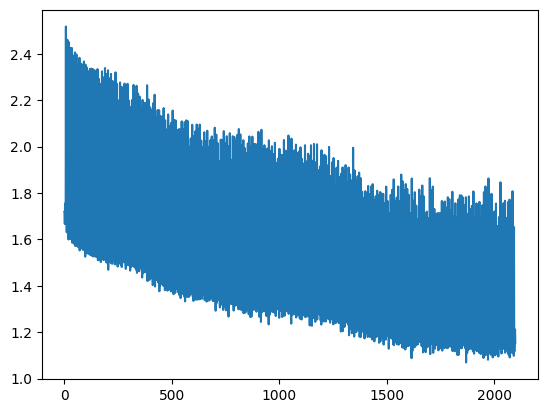

In [ ]:
net = MultiFCn(5,5)
number_of_epochs = 300
optimizer = optim.Adam(net.parameters(), lr=1e-4)
list_loss = []
running_loss = 0
for epoch in range(number_of_epochs):
    net.train()
    indb = 0
    with tqdm(total=len(dataloader), file=sys.stdout) as pbar:
        start_time = time.time()
        for (i,sample) in enumerate(dataloader):
            output = net(sample['data'].float())
            loss = cross_entropy(output,sample['label'])
            net.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            # print(loss.item())
            indb += 1
            if i%10 == 9:
                if i%50 == 49:
                    print('Epoch ', epoch, ' Loss ', running_loss/10)
                list_loss.append(running_loss/10)
                running_loss = 0
            pbar.update(1)
from matplotlib import pyplot as plt
plt.plot(np.asarray(list_loss))

In [ ]:
rfc = RFC()
rfc.fit(df_train[list_feat], df_train['diagnosis'])
pred_rfc = rfc.predict_proba(df_test[list_feat])
pred_rfc_val = rfc.predict_proba(df_valid[list_feat])
final_class_rfc = np.argmax(pred_rfc,1)

In [ ]:
def get_whole_test_output(model, testloader):
    model.eval()
    sig = nn.Softmax(dim=1)
    list_output = []
    list_labels = []
    for (i, sample) in enumerate(testloader):
        labels = sample['label']
        output = sig(model(sample['data'].float()))
        list_output.append(output)
        list_labels.append(labels)
    tot_out = torch.cat(list_output)
    tot_lab = torch.cat(list_labels)
    return tot_out, tot_lab

In [ ]:
out_pred, out_lab = get_whole_test_output(net, testloader)
out_pred_val, out_lab_val = get_whole_test_output(net, validloader)
pred_net = out_pred.detach().numpy()
val_net = out_pred_val.detach().numpy()
lab = out_lab.numpy()

In [ ]:
out_pred_val, out_lab_val = get_whole_test_output(net, validloader)
val_smx = out_pred_val.detach().numpy()
lab_val = out_lab_val.numpy()
test_smx = pred_net
n = val_smx.shape[0]
val_scores_nn = 1- val_smx[np.arange(n),lab_val]
alpha=0.1
q = np.ceil((n+1)*(1-alpha)/n*100)/100
qhat_nn = np.quantile(val_scores_nn,q)
pred_test_set_nn = test_smx >= (1-qhat_nn)

In [ ]:
ohe = OHE(sparse_output=False)
label_ohe = ohe.fit_transform(np.reshape(out_lab,[-1,1]))

ohe_val = OHE(sparse_output=False)
label_ohe_val= ohe_val.fit_transform(np.reshape(out_lab_val,[-1,1]))

In [ ]:
val_scores_rfc = 1 - pred_rfc_val[np.arange(n),lab_val]
qhat_rfc = np.quantile(val_scores_rfc, q)
pred_test_set_rfc = pred_rfc >= (1-qhat_rfc)

In [ ]:
size_pred_test_nn = np.sum(pred_test_set_nn.astype(int),1)
np.unique(size_pred_test_nn, return_counts=True)

(array([1, 2, 3, 4]), array([ 24, 109, 142,  98]))

In [ ]:
size_pred_test_rfc = np.sum(pred_test_set_rfc.astype(int),1)
np.unique(size_pred_test_rfc, return_counts=True)

(array([1, 2, 3, 4, 5]), array([ 33,  81, 118, 135,   6]))

Let's evaluate the quality of our conformal prediction according to the size coverage index metric

In [ ]:
def ssc(pred_test_set, label_ohe):
    comp_agreement = np.diag(np.dot(pred_test_set, label_ohe.T))
    size_pred_test = np.sum(pred_test_set.astype(int),1)
    list_valid = []
    for k in range(1,5):
        ind = np.where(size_pred_test == k)
        valid_set_mean = np.mean(comp_agreement[ind])
        list_valid.append(valid_set_mean)
    return list_valid

In [ ]:
ssc(pred_test_set_nn, label_ohe)

[1.0, 0.8623853211009175, 0.8943661971830986, 1.0]

In [ ]:
ssc(pred_test_set_rfc, label_ohe)

[0.9393939393939394,
 0.8271604938271605,
 0.8898305084745762,
 0.9703703703703703]